In [1]:
#import 
import pandas as pd 
import numpy as np 
import seaborn as sns 
from requests import get
import fmpclient
from collections import defaultdict
import matplotlib.pyplot as plt 

In [2]:
api = fmpclient.FMPClient()

In [39]:
stock_list = ['TZOO','XRX','OXY',
             'EBIX','XSPA','NSP','ROSE', 
             'AXTA','CSU','FLDM','STOR','AAL','CHK',
             'HUD','NUS','AXAS','SITO','STIM','SYF','SU','STNE','GM','BAC','DAL','BAK',
             'BKEP','T','KHC','WLKP','MDWD','VGR','MN','SALM','VOXX','BBGI','CPLP',
              'SIF','OIIM','SMLP',
              'OCSL','CMRE','RELL', "NL", 'LYTS', 'LCUT', "HMST","MN","SM",'DGICB', 'PTVCA', 
              'GBLI', 'CFNB','FBP'
             ]

In [4]:
def url_import(stock_list, info_type,params = {'datatype': 'json'}): 
    
    
    #dict_info = dict_maker(stock_list)
    dict_info = defaultdict(list)
    err_list = []
    url_list = ['''https://fmpcloud.io/api/v3/{info_type}/{stock}?apikey=cb3b0c371586d9ce915d359479fe1c81'''
                .format(info_type=info_type, stock = stock) 
    for stock in stock_list]

    print(url_list[0])
    for url, stock in zip(url_list,stock_list):
        try:
            #import financial ratios
            financial = api.requester.GET(url, params)
           
        
            for period_dict in financial: 

                for key, value in period_dict.items():
                    

                   # if key == 'date': 
                    #    dict_info[stock]['date'].append(value)
                    
                    dict_info[key].append(value)
        
        except: 
            err_list.append(stock)
            pass 
        
        
    
            
    return dict_info, err_list       

In [5]:
def url_import_latest(stock_list, info_type,params = {'datatype': 'json'}): 
    
    
    #dict_info = dict_maker(stock_list)
    dict_info = defaultdict(list)
    err_list = []
    url_list = ['''https://fmpcloud.io/api/v3/{info_type}/{stock}?apikey=cb3b0c371586d9ce915d359479fe1c81'''
                .format(info_type=info_type, stock = stock) 
    for stock in stock_list]

    print(url_list[0])
    for url, stock in zip(url_list,stock_list):
        try:
            #import financial ratios
            financial = api.requester.GET(url, params)
           
        

            for key, value in financial[0].items():
                
                    

                   # if key == 'date': 
                    #    dict_info[stock]['date'].append(value)
                    
                dict_info[key].append(value)
        
        except: 
            err_list.append(stock)
            pass 
        
        
    
            
    return dict_info, err_list

In [724]:
def intrinsic_cash(cf_ests, grs,drs, lgr,shares,n):
    iv_dict = defaultdict(list)
    for cf_est in cf_ests: 
        for gr in grs: 
            iv_dict['{},{}%'.format(cf_est/1000,gr*100)] = []
            for dr in drs: 
                
                fcfn = [ cf_est * (1 + gr)**i for i in range(1,n+1)]
                dfn = [(1+dr)**i for i in range(1,n+1)]
                dcf = sum([fcf/df for fcf, df in zip(fcfn,dfn)])
                dpcf = ((cf_est * (1 + gr)**(n+1) * (1 + lgr)) / (dr - lgr)) * (1 / (1 + dr)**(n+1))
                iv = (dcf + dpcf) / shares
                iv_dict['{},{}%'.format(cf_est/1000,gr*100)].append(iv)
    return iv_dict

In [963]:
def intrn_avg(dict_iv): 
    dict_final = defaultdict(float)
    for key, value in dict_iv.items():
        dict_final[key] = np.mean(value)
    return dict_final
        

In [488]:
def intrinsic_bk(avg_div_yr, pbvPersh_est, gr,dr,n): 
    fbv = pbvPersh_est * (1 + gr)**n 
    div = avg_div_yr * ((1 - (1 / (1 + dr)**n)) / dr)
    return div + (fbv / (1 + dr)**n)

In [564]:
def annual_growth(f,i,n): 
    return ((f/i)**(1/n) - 1)

In [6]:
df_filter = pd.read_clipboard()

In [8]:
df_filter.dtypes

Company Name          object
Ticker                object
Stock Price           object
% Price Change        object
Dividend Yield        object
Industry              object
Price to Book         object
Relative P/E Ratio    object
dtype: object

In [12]:
import re

In [40]:
dict_main,err_main = url_import_latest(stock_list,'quote')

https://fmpcloud.io/api/v3/quote/TZOO?apikey=cb3b0c371586d9ce915d359479fe1c81


In [41]:
df_main = pd.DataFrame(dict_main)

In [42]:
#drop bs 
df_main.drop(['dayLow',
       'dayHigh','exchange', 'open',
       'previousClose','timestamp'], axis = 1,inplace = True)

In [43]:
#making columns
rtrn_high = (2000/df_main['price']) * df_main['yearHigh']
rtrn_avg200 = (2000/df_main['price']) *df_main['priceAvg200']
rtrn_avg50 = (2000/df_main['price']) *df_main['priceAvg50']
rtrn_avg = (2000/df_main['price']) *df_main[['priceAvg50','priceAvg200','yearHigh']].mean(axis = 1)
pct_change200 = np.round((df_main['price'] - df_main['priceAvg200'])/df_main['priceAvg200'] 
                          * 100, 2)

                          
pct_change_50 = np.round((df_main['price'] - df_main['priceAvg50'])/df_main['priceAvg50'] 
                          * 100, 2)


In [44]:
df_main.insert(5,'pct_change50', pct_change_50)
df_main.insert(6,'pct_change200',pct_change200)

In [45]:
df_main['rtrn_high'] = rtrn_high
df_main['rtrn_avg200'] = rtrn_avg200
df_main['rtrn_avg50'] = rtrn_avg50
df_main['rtrn_avg'] = rtrn_avg

In [46]:
df_main['dol_vol'] = df_main['price'] * df_main['avgVolume']

In [47]:
def volume_type(x): 
        
        typ = ''
        if x <= 2E06:
            typ ='l'
        elif x > 100E06: 
            typ = 'h'
        else: 
            typ = 'n'
    
        return typ

In [48]:
df_main.drop(['volume', 'avgVolume'],axis = 1,inplace = True)

In [49]:
df_main['vol_type'] = df_main['dol_vol'].apply(lambda x: volume_type(x))

In [50]:
df_main.drop('earningsAnnouncement',axis = 1, inplace = True)

In [51]:
pd.set_option('display.max_columns', None)

In [52]:
df_main.set_index('symbol',inplace = True)

In [53]:
df_main

,name,price,changesPercentage,change,pct_change50,pct_change200,yearHigh,yearLow,marketCap,priceAvg50,priceAvg200,eps,pe,sharesOutstanding,rtrn_high,rtrn_avg200,rtrn_avg50,rtrn_avg,dol_vol,vol_type
symbol,,,,,,,,,,,,,,,,,,,,
TZOO,Travelzoo,5.3237,6.69,0.3337,18.03,-40.23,22.85,3.040,6.021318e+07,4.510294,8.907352,0.350,15.210571,11310400,8584.255311,3346.301257,1694.420798,4541.659122,7.490180e+05,l
GTX,Garrett Motion Inc.,4.5100,4.88,0.2100,20.98,-44.42,19.26,2.500,3.408279e+08,3.727941,8.114486,4.120,1.094660,75571600,8541.019956,3598.441685,1653.189047,4597.550229,4.668306e+06,n
LXRX,"Lexicon Pharmaceuticals, Inc.",2.2803,11.23,0.2303,13.88,-29.51,7.27,1.130,2.439237e+08,2.002353,3.234926,1.158,1.969171,106970000,6376.353989,2837.281498,1756.218919,3656.618135,2.141519e+06,n
MCFT,"MasterCraft Boat Holdings, Inc.",10.3500,11.41,1.0600,33.95,-27.21,26.74,4.900,1.953273e+08,7.726911,14.219816,0.974,10.626284,18872200,5167.149758,2747.790531,1493.122995,3136.021095,3.312031e+06,n
MIK,"The Michaels Companies, Inc.",2.7400,16.10,0.3800,22.45,-53.64,12.42,1.000,4.023608e+08,2.237647,5.909632,1.777,1.541925,146784992,9065.693431,4313.600000,1633.318978,5004.204136,1.347640e+07,n
TUP,Tupperware Brands Corporation,2.1500,4.88,0.1000,17.45,-68.87,24.16,1.150,1.052877e+08,1.830588,6.905588,0.250,8.600000,48971000,22474.418605,6423.802791,1702.872744,10200.364713,6.350277e+06,n
XRX,Xerox Holdings Corporation,17.9550,-0.08,-0.0150,-6.56,-43.33,39.47,15.010,3.821381e+09,19.216177,31.681177,5.803,3.094089,212831008,4396.546923,3528.953161,2140.481983,3355.327355,5.645350e+07,n
OXY,Occidental Petroleum Corporation,14.2500,3.19,0.4400,12.88,-57.25,60.73,9.000,1.306407e+10,12.623529,33.333824,-1.219,NaN,916777024,8523.508772,4678.431439,1771.723368,4991.221193,5.206230e+08,h
EBIX,"Ebix, Inc.",19.3200,10.91,1.9000,20.81,-36.32,53.94,8.750,5.887905e+08,15.992353,30.338015,3.160,6.113924,30475700,5583.850932,3140.581263,1655.523033,3459.985076,1.214907e+07,n


# analysis start: AGS

In [54]:
dict_ags_income,errs_ags = url_import(['AGS'], 'income-statement')

https://fmpcloud.io/api/v3/income-statement/AGS?apikey=cb3b0c371586d9ce915d359479fe1c81


In [132]:
df_ags_income = pd.DataFrame(dict_ags_income)

In [133]:
df_ags_income.date = df_ags_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [134]:
df_ags_income.set_index(['date'], inplace = True)

In [67]:
dict_ags_cash,errs_ags = url_import(['AGS'], 'cash-flow-statement')
dict_ags_balance,errs_ags = url_import(['AGS'], 'balance-sheet-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/AGS?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/AGS?apikey=cb3b0c371586d9ce915d359479fe1c81


In [135]:
df_ags_cash = pd.DataFrame(dict_ags_cash)
df_ags_bal = pd.DataFrame(dict_ags_balance)

In [136]:
df_ags_bal.date = df_ags_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_ags_cash.date = df_ags_cash.date.map(lambda x: re.sub(r'-.*$','',x))

In [137]:
df_ags_bal.set_index(['date'], inplace = True)
df_ags_cash.set_index(['date'], inplace = True)

In [114]:
df_ags_cash = df_ags_cash.T
df_ags_bal = df_ags_bal.T
df_ags_income = df_ags_income.T

In [161]:
df_ags = pd.concat([df_ags_income,df_ags_bal,df_ags_cash],axis = 1)

In [176]:
df_ags.drop(['symbol','period'],axis = 1, inplace =True)

In [179]:
df_ags = df_ags/1000

In [183]:
df_ags['shares'] = df_main.loc['AGS','sharesOutstanding'] / 1000

In [202]:
df_ags[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio']] = df_ags[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio']] * 1000

In [188]:
df_ags = df_ags.sort_index()

# Principle 1: vigilant leadership 

# rule 1: D/E 

In [203]:
df_ags_look = df_ags.T

In [204]:
df_ags['d/e'] = df_ags['totalDebt'] / df_ags['totalStockholdersEquity']

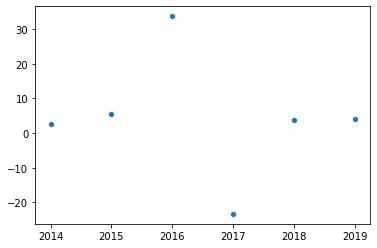

In [205]:
sns.scatterplot(data = df_ags['d/e'])

In [206]:
df_ags['d/e']

date
2014     2.614483
2015     5.451117
2016    33.709216
2017   -23.322606
2018     3.887095
2019     3.922195
Name: d/e, dtype: float64

In [207]:
df_ags

,revenue,costOfRevenue,grossProfit,grossProfitRatio,researchAndDevelopmentExpenses,generalAndAdministrativeExpenses,sellingAndMarketingExpenses,otherExpenses,operatingExpenses,costAndExpenses,interestExpense,depreciationAndAmortization,ebitda,ebitdaratio,operatingIncome,operatingIncomeRatio,totalOtherIncomeExpensesNet,incomeBeforeTax,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,goodwill,intangibleAssets,goodwillAndIntangibleAssets,longTermInvestments,taxAssets,otherNonCurrentAssets,totalNonCurrentAssets,otherAssets,totalAssets,accountPayables,shortTermDebt,taxPayables,deferredRevenue,otherCurrentLiabilities,totalCurrentLiabilities,longTermDebt,deferredRevenueNonCurrent,deferrredTaxLiabilitiesNonCurrent,otherNonCurrentLiabilities,totalNonCurrentLiabilities,otherLiabilities,totalLiabilities,commonStock,retainedEarnings,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalLiabilitiesAndStockholdersEquity,totalInvestments,totalDebt,netDebt,netIncome,depreciationAndAmortization,deferredIncomeTax,stockBasedCompensation,changeInWorkingCapital,accountsReceivables,inventory,accountsPayables,otherWorkingCapital,otherNonCashItems,netCashProvidedByOperatingActivites,investmentsInPropertyPlantAndEquipment,acquisitionsNet,purchasesOfInvestments,salesMaturitiesOfInvestments,otherInvestingActivites,netCashUsedForInvestingActivites,debtRepayment,commonStockIssued,commonStockRepurchased,dividendsPaid,otherFinancingActivites,netCashUsedProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow,d/e,shares,curr
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014,72140.0,1607.0,70533.0,0.977724,1800.0,22708.0,3530.0,52523.0,80561.0,82168.0,17235.0,34647.0,26226.0,0.363543,-8421.0,-0.116731,0.0,-26187.0,-0.363002,2189.0,-28376.0,-0.393346,-0.00284,-0.00284,10000.000,10000.000,10680.0,0.0,10680.0,8835.0,3175.0,4503.0,27193.0,40769.0,77617.0,101885.0,179502.0,0.0,528.0,8160.0,228959.0,0.0,256152.0,22795.0,2495.0,0.0,0.0,1049.0,26339.0,164194.0,0.0,1863.0,0.0,166057.0,0.0,192396.0,100.0,-36532.0,288.0,99900.0,63756.0,256152.0,0.0,166689.0,156009.0,-28376.0,34647.0,-2189.0,0.0,0.0,0.0,806.0,2762.0,0.0,0.0,12482.0,0.0,0.0,0.0,0.0,-33922.0,-33922.0,0.0,0.0,-10680.0,0.0,20540.0,9860.0,518.0,-11062.0,10680.0,21742.0,12482.0,9259.0,3223.0,2.614483,35534.6,1.032423
2015,123292.0,1548.0,121744.0,0.987444,14376.0,546.0,0.0,0.0,14922.0,16470.0,8123.0,61805.0,61259.0,0.496861,-546.0,-0.004429,0.0,-74634.0,-0.605343,-3528.0,-38545.0,-0.312632,-0.00298,-0.00298,12918.000,12918.000,25972.0,-33117.0,25972.0,23653.0,7087.0,2440.0,26035.0,66699.0,253851.0,290356.0,544207.0,203390.0,0.0,-606850.0,207446.0,0.0,233481.0,23030.0,6919.0,2440.0,0.0,-32369.0,20.0,541120.0,0.0,15347.0,1271.0,557738.0,0.0,132944.0,149.0,-75077.0,-1811.0,177276.0,100537.0,233481.0,170273.0,548039.0,522067.0,-38545.0,61805.0,-38645.0,0.0,0.0,0.0,1144.0,7956.0,0.0,0.0,-108.0,-15277.0,-374347.0,-277.0,0.0,218739.0,-171162.0,-4743.0,77425.0,-277.0,0.0,116324.0,188729.0,-58.0,17459.0,25972.0,8513.0,-108.0,21379.0,-21487.0,5.451117,35534.6,1301.750000
2016,166806.0,6237.0,160569.0,0.962609,21346.0,46108.0,0.0,116416.0,183870.0,190107.0,59963.0,83723.0,66659.0,0.399620,-17064.0,-0.102298,0.0,-84374.0,-0.505821,-3000.0,-81374.0,-0.487836,-0.00545,-0.00545,14932.000,14932.000,17977.0,2709.0,17977.0,24035.0,10729.0,3052.0,58502.0,67926.0,251024.0,232877.0,483901.0,153926.0,9.0,-130172.0,575590.0,0.0,634092.0,8790.0,6537.0,2128.0,0.0,15574.0,33029.0,547238.0,0.0,6957.0,30440.0,584635.0,0.0,617664.0,149.0,-156451.0,-4546.0,177276.0,16428.0,634092.0,156635.0,553775.0,5

In [200]:
[x for x in df_ags.columns if re.findall(r'^.*(ratio|Ratio)$',x)]

['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio']

# D/e 

-even discounting the really bad year we see that the company is consistently incurring a 3 to 1 d/e ratio

-d/e == HUGE red flag

-they had a big hit due to paying off loans and the year was very bad

In [194]:
# avg d/e 
df_ags['d/e'].mean()

4.376916813402219

In [214]:
df_ags['netIncome']

,netIncome,netIncome
date,,
2014,-28376.0,-28376.0
2015,-38545.0,-38545.0
2016,-81374.0,-81374.0
2017,-45106.0,-45106.0
2018,-20846.0,-20846.0
2019,-11752.0,-11521.0


# red flag 2: no earnings ever!!!

# current ratio: cash earned and debt 

can they become profitable 

In [195]:
df_ags['curr'] = df_ags['totalCurrentAssets'] / df_ags['totalCurrentLiabilities']

In [212]:
df_ags['curr']

date
2014       1.032423
2015    1301.750000
2016       1.771231
2017       1.891766
2018       3.177618
2019       2.046816
Name: curr, dtype: float64

In [213]:
#very weird thing happened in 2015 
df_ags.loc['2015']

revenue                                     123292.000000
costOfRevenue                                 1548.000000
grossProfit                                 121744.000000
grossProfitRatio                                 0.987444
researchAndDevelopmentExpenses               14376.000000
generalAndAdministrativeExpenses               546.000000
sellingAndMarketingExpenses                      0.000000
otherExpenses                                    0.000000
operatingExpenses                            14922.000000
costAndExpenses                              16470.000000
interestExpense                               8123.000000
depreciationAndAmortization                  61805.000000
ebitda                                       61259.000000
ebitdaratio                                      0.496861
operatingIncome                               -546.000000
operatingIncomeRatio                            -0.004429
totalOtherIncomeExpensesNet                      0.000000
incomeBeforeTa

In [216]:
#consistently no earnings 
#they spent a lot of money aquiring something in 2015 
#current ratio is pretty good 
#payment structre does affect the earnings 

# 3 ROE 

In [228]:
df_ags['roe'] = (df_ags_income['netIncome'] / 1000) / df_ags['totalStockholdersEquity']

In [229]:
df_ags['roe']

date
2014   -0.445072
2015   -0.383391
2016   -4.953372
2017    1.614677
2018   -0.153501
2019   -0.087843
Name: roe, dtype: float64

In [230]:
# Terrible usage of Equity 

In [231]:
df_ags['roa'] = (df_ags_income['netIncome'] / 1000) / df_ags['totalAssets']

In [232]:
df_ags['roa']

date
2014   -0.110778
2015   -0.165088
2016   -0.128332
2017   -0.064692
2018   -0.028504
2019   -0.015415
Name: roa, dtype: float64

In [233]:
#terrible return on assets 

# failed 3 out of 4 of principle 1 (current was good) 
# ROE IS A MUST SO IT'S DISQUALIFIED 

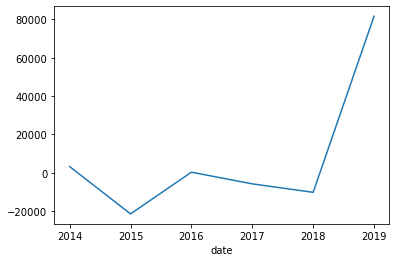

In [236]:
df_ags['freeCashFlow'].plot()

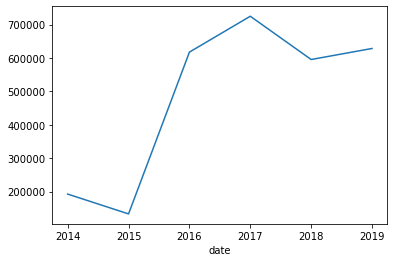

In [238]:
df_ags['totalLiabilities'].plot()

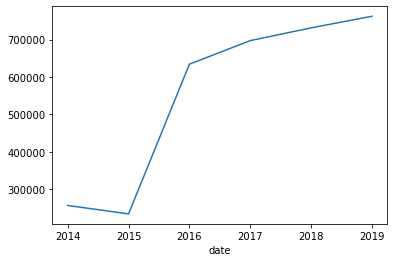

In [240]:
df_ags['totalAssets'].plot()

# highly unpredictable --> not worth it 
# result --> sell current stake 

In [242]:
#equity concentration -> assets --> but ROA sucks too 
#nah 

# FLDM 

In [248]:
dict_fldm_income,errs_fldm = url_import(['FLDM'], 'income-statement')

https://fmpcloud.io/api/v3/income-statement/FLDM?apikey=cb3b0c371586d9ce915d359479fe1c81


In [258]:
df_fldm_income = pd.DataFrame(dict_fldm_income)

In [259]:
df_fldm_income.date = df_fldm_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [260]:
df_fldm_income.set_index(['date'], inplace = True)

In [253]:
dict_fldm_cash,errs_fldm = url_import(['FLDM'], 'cash-flow-statement')
dict_fldm_balance,errs_fldm = url_import(['FLDM'], 'balance-sheet-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/FLDM?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/FLDM?apikey=cb3b0c371586d9ce915d359479fe1c81


In [261]:
df_fldm_cash = pd.DataFrame(dict_fldm_cash)
df_fldm_bal = pd.DataFrame(dict_fldm_balance)

In [262]:
df_fldm_bal.date = df_fldm_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_fldm_cash.date = df_fldm_cash.date.map(lambda x: re.sub(r'-.*$','',x))

In [263]:
df_fldm_bal.set_index(['date'], inplace = True)
df_fldm_cash.set_index(['date'], inplace = True)

In [264]:
df_fldm = pd.concat([df_fldm_income,df_fldm_bal,df_fldm_cash],axis = 1)

In [265]:
df_fldm.drop(['symbol','period'],axis = 1, inplace =True)

In [266]:
df_fldm = df_fldm/1000

In [267]:
df_fldm['shares'] = df_main.loc['FLDM','sharesOutstanding'] / 1000

In [268]:
df_fldm[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio']] = df_fldm[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio']] * 1000

In [269]:
df_fldm = df_fldm.sort_index()

In [276]:
df_fldm_main = df_fldm[['netIncomeRatio','totalLiabilities','totalAssets','d/e','totalStockholdersEquity']]

In [284]:
df_fldm_main.loc[:,'ern'] = df_fldm_income['netIncome'] / 1000

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# D/E 

In [271]:
df_fldm['d/e'] = df_fldm['totalDebt'] / df_fldm['totalStockholdersEquity']

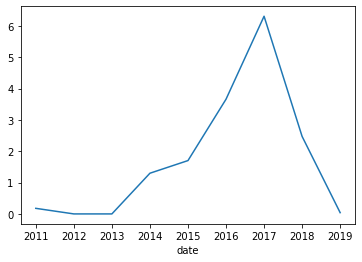

In [273]:
df_fldm['d/e'].plot()

In [287]:
df_fldm_main['d/e'].mean()

1.7408627403784154

In [291]:
#high d/e ratio
print(f"D/E: {df_fldm_main['d/e'].values[-1]} \
        \n D/E_avg: {df_fldm_main['d/e'].values[3:].mean()}")

D/E: 0.040074994141082725         
 D/E_avg: 2.5815971728263247


In [292]:
#two times more debt than equity 
# current D/E is pretty good 

# D/E 
# not the best with a high average 
# very good in recent years 
# pass 

# current ratio 
# assets and liabilities 

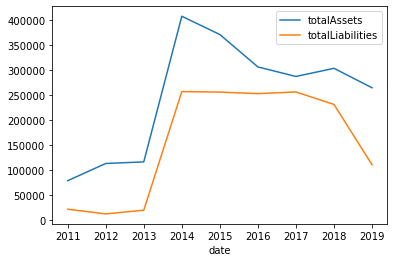

In [286]:
df_fldm_main[['totalAssets','totalLiabilities']].plot()

In [293]:
# good trend for assets and liabilities 

In [294]:
#current ratio 
df_fldm_main['curr'] = df_fldm['totalCurrentAssets'] / df_fldm['totalCurrentLiabilities']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


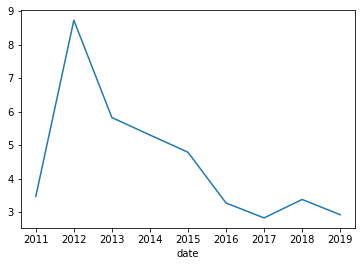

In [297]:
df_fldm_main['curr'].plot()

In [319]:
df_fldm_main.curr, df_fldm_main.curr.mean()

(date
 2011    3.471965
 2012    8.727343
 2013    5.826082
 2014    5.305326
 2015    4.790233
 2016    3.276983
 2017    2.832079
 2018    3.382098
 2019    2.927882
 Name: curr, dtype: float64,
 4.504443334190476)

# current ratio  is in allignment 

# ROE ANALYSIS

In [300]:
df_fldm_main['roe'] = df_fldm_main['ern'] / df_fldm['totalStockholdersEquity']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [302]:
df_fldm_main

,netIncomeRatio,totalLiabilities,totalAssets,d/e,totalStockholdersEquity,ern,curr,roe
date,,,,,,,,
2011,-0.524204,22429.0,79326.0,0.178182,56897.0,-22470.0,3.471965,-0.394924
2012,-0.363511,13075.0,113732.0,0.000000,100657.0,-19024.0,8.727343,-0.188998
2013,-0.232162,20501.0,116915.0,0.000000,96414.0,-16526.0,5.826082,-0.171407
2014,-0.453648,257140.0,407559.0,1.299404,150419.0,-52830.0,5.305326,-0.351219
2015,-0.464773,256160.0,371061.0,1.703066,114901.0,-53315.0,4.790233,-0.464008
2016,-0.727505,253162.0,306395.0,3.662221,53233.0,-75985.0,3.276983,-1.427404
2017,-0.593847,256416.0,287351.0,6.311233,30935.0,-60535.0,2.832079,-1.956845
2018,-0.522405,231531.0,303647.0,2.473584,72116.0,-59013.0,3.382098,-0.818307
2019,-0.552613,111200.0,264812.0,0.040075,153612.0,-64790.0,2.927882,-0.421777


<Figure size 432x288 with 0 Axes>

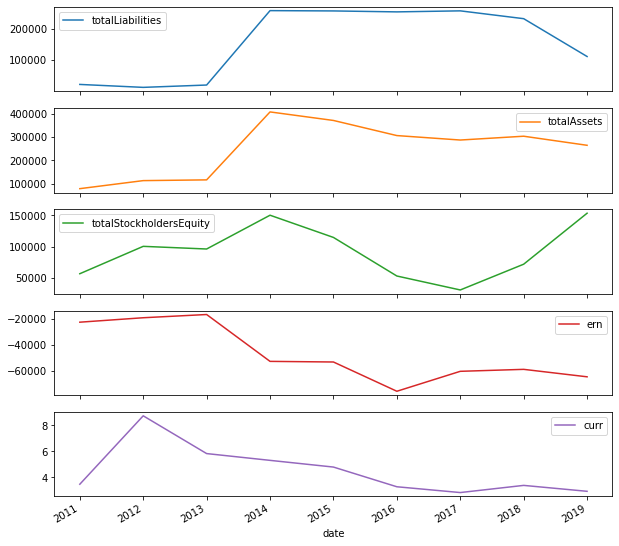

In [310]:
#earnings is negative so equity not going to increase profit 
plt.figure()
df_fldm_main.iloc[:,[1,2,4,5,6]].plot(subplots = (2,2), figsize = (10,10))
plt.show()

# since everything is constant outside of equity and liabilities 
# can say equity went to pay off the liabilities incurred in earlier yrs

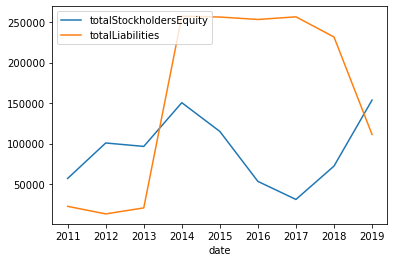

In [312]:
df_fldm_main[['totalStockholdersEquity','totalLiabilities']].plot()

# determined that they are efficiently using equity to pay off debt

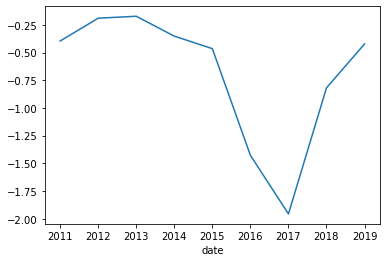

In [313]:
#plotting roe
df_fldm_main['roe'].plot()

In [314]:
df_fldm_main['roa'] = df_fldm_main['ern'] / df_fldm['totalAssets']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


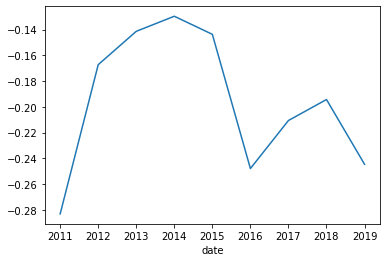

In [315]:
df_fldm_main.roa.plot()

In [318]:
df_fldm_main.roa.pct_change().mean()

0.027245819805727864

In [321]:
df_fldm_main.iloc[:,[1,2]]

,totalLiabilities,totalAssets
date,,
2011,22429.0,79326.0
2012,13075.0,113732.0
2013,20501.0,116915.0
2014,257140.0,407559.0
2015,256160.0,371061.0
2016,253162.0,306395.0
2017,256416.0,287351.0
2018,231531.0,303647.0
2019,111200.0,264812.0


In [328]:
#BV GROWTH RATE 
df_fldm_main['totalStockholdersEquity'].pct_change().mean()

0.31958290652090227

# increasing ROE 
# Good money managment in using equity to pay debt 
# D/E is looking good 

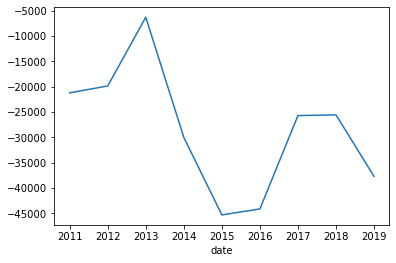

In [330]:
df_fldm['freeCashFlow'].plot()

# principle 3
# Book Value analysis, effects, growth rate, BV/ SHARE 

In [334]:
df_fldm['researchAndDevelopmentExpenses'].pct_change().mean()

0.1602808166887493

# Result: 
# Highly volatile earnings, revenues, prospects 
# way too much uncertainty 
# keep current stake --> sell at principal recovery

# VGR analysis (keep or drop)

In [336]:
dict_vgr_income,errs_vgr = url_import(['VGR'], 'income-statement')

https://fmpcloud.io/api/v3/income-statement/VGR?apikey=cb3b0c371586d9ce915d359479fe1c81


In [337]:
df_vgr_income = pd.DataFrame(dict_vgr_income)

In [338]:
df_vgr_income.date = df_vgr_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [339]:
df_vgr_income.set_index(['date'], inplace = True)

In [340]:
dict_vgr_cash,errs_vgr = url_import(['VGR'], 'cash-flow-statement')
dict_vgr_balance,errs_vgr = url_import(['VGR'], 'balance-sheet-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/VGR?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/VGR?apikey=cb3b0c371586d9ce915d359479fe1c81


In [341]:
df_vgr_cash = pd.DataFrame(dict_vgr_cash)
df_vgr_bal = pd.DataFrame(dict_vgr_balance)

In [342]:
df_vgr_bal.date = df_vgr_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_vgr_cash.date = df_vgr_cash.date.map(lambda x: re.sub(r'-.*$','',x))

In [343]:
df_vgr_bal.set_index(['date'], inplace = True)
df_vgr_cash.set_index(['date'], inplace = True)

In [344]:
df_vgr = pd.concat([df_vgr_income,df_vgr_bal,df_vgr_cash],axis = 1)

In [345]:
df_vgr.drop(['symbol','period'],axis = 1, inplace =True)

In [346]:
df_vgr = df_vgr/1000

In [348]:
df_vgr['shares'] = 148085

In [349]:
df_vgr[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio']] = df_vgr[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio']] * 1000

In [352]:
df_vgr = df_vgr.sort_index()

In [354]:
df_vgr_main = df_vgr[['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [356]:
df_vgr_main['netIncome'] = df_vgr_income['netIncome'] / 1000

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# principle 1

# D/E analysis

In [358]:
df_vgr_main['de'] = df_vgr['totalDebt'] / df_vgr['totalStockholdersEquity']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [359]:
df_vgr_main

,netIncomeRatio,totalLiabilities,totalAssets,totalStockholdersEquity,netIncome,de
date,,,,,,
2010,0.000000,0.0,0.0,0.0,0.0,NaN
2011,0.066191,1016798.0,927768.0,-89030.0,75020.0,-6.112546
2012,0.028235,1165983.0,1086731.0,-79252.0,30622.0,-7.870136
2013,0.036633,1355195.0,1260159.0,-95036.0,38692.0,-7.285060
2014,0.023237,1630419.0,1573392.0,-57027.0,36978.0,-16.016115
2015,0.035722,1516803.0,1310756.0,-206047.0,59198.0,-4.344485
2016,0.042063,1736035.0,1404035.0,-332000.0,71127.0,-3.531479
2017,0.046790,1742197.0,1328278.0,-413919.0,84572.0,-2.966919
2018,0.031068,2097563.0,1549504.0,-548059.0,58105.0,-2.997544


# negative equity!!

In [360]:
df_vgr_main['eps'] = df_vgr_main['netIncome'] / df_vgr['shares']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [362]:
#current analysis 
df_vgr['totalCurrentAssets'] / df_vgr['totalCurrentLiabilities']

date
2010         NaN
2011    1.617209
2012    3.274540
2013    1.452602
2014    3.176090
2015    2.698847
2016    3.596585
2017    2.998984
2018    1.798691
2019    1.478129
dtype: float64

In [363]:
#current ratio is fine --> they make enough cash to stay afloat 

In [364]:
df_vgr['freeCashFlow'] / df_vgr['revenue']

date
2010         NaN
2011    0.021355
2012    0.067144
2013    0.036689
2014    0.052769
2015    0.080559
2016    0.041956
2017    0.061808
2018    0.087770
2019    0.058568
dtype: float64

In [365]:
#enough fcf is available 
df_vgr

,revenue,costOfRevenue,grossProfit,grossProfitRatio,researchAndDevelopmentExpenses,generalAndAdministrativeExpenses,sellingAndMarketingExpenses,otherExpenses,operatingExpenses,costAndExpenses,interestExpense,depreciationAndAmortization,ebitda,ebitdaratio,operatingIncome,operatingIncomeRatio,totalOtherIncomeExpensesNet,incomeBeforeTax,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,goodwill,intangibleAssets,goodwillAndIntangibleAssets,longTermInvestments,taxAssets,otherNonCurrentAssets,totalNonCurrentAssets,otherAssets,totalAssets,accountPayables,shortTermDebt,taxPayables,deferredRevenue,otherCurrentLiabilities,totalCurrentLiabilities,longTermDebt,deferredRevenueNonCurrent,deferrredTaxLiabilitiesNonCurrent,otherNonCurrentLiabilities,totalNonCurrentLiabilities,otherLiabilities,totalLiabilities,commonStock,retainedEarnings,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalLiabilitiesAndStockholdersEquity,totalInvestments,totalDebt,netDebt,netIncome,depreciationAndAmortization,deferredIncomeTax,stockBasedCompensation,changeInWorkingCapital,accountsReceivables,inventory,accountsPayables,otherWorkingCapital,otherNonCashItems,netCashProvidedByOperatingActivites,investmentsInPropertyPlantAndEquipment,acquisitionsNet,purchasesOfInvestments,salesMaturitiesOfInvestments,otherInvestingActivites,netCashUsedForInvestingActivites,debtRepayment,commonStockIssued,commonStockRepurchased,dividendsPaid,otherFinancingActivites,netCashUsedProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow,shares
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.00000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,148085
2011,1133380.0,892883.0,240497.0,0.212194,1152.0,0.0,0.0,96024.0,97176.0,990059.0,100706.0,10607.0,153928.0,0.135813,143321.0,0.126454,0.0,123157.0,0.108663,48137.0,75020.0,0.066191,0.00093,0.00093,78674.311,78876.810,240923.0,76486.0,317409.0,24869.0,109228.0,58235.0,509741.0,56556.0,0.0,107511.0,107511.0,5675.0,31017.0,217268.0,418027.0,0.0,927768.0,9532.0,50844.0,6597.0,0.0,248225.0,315198.0,493356.0,0.0,60642.0,1667.0,555665.0,145935.0,1016798.0,7944.0,-80440.0,-3677.0,0.0,-89030.0,927768.0,82161.0,544200.0,303277.0,75020.0,10607.0,-9366.0,3183.0,0.0,0.0,-2149.0,-3216.0,0.0,0.0,36041.0,-11838.0,0.0,0.0,-23257.0,76380.0,41285.0,-4960.0,0.0,-240923.0,-125299.0,234954.0,-136228.0,0.0,-58902.0,240923.0,299825.0,36041.0,11838.0,24203.0,148085
2012,1084546.0,823452.0,261094.0,0.240740,0.0,0.0,0.0,106161.0,106161.0,929613.0,110102.0,10608.0,165541.0,0.152636,154933.0,0.142855,0.0,53717.0,0.049529,23095.0,30622.0,0.028235,0.00035,0.00035,84612.613,84692.996,405855.0,69984.0,475839.0,11247.0,100392.0,51578.0,639056.0,57153.0,0.0,107511.0,107511.0,16367.0,49142.0,217502.0,447675.0,0.0,1086731.0,6099.0,36778.0,6269.0,0.0,146013.0,195159.0,586946.0,0.0,109532.0,1857.0,698335.0,272489.0,1165983.0,8989.0,-65116.0,-10268.0,0.0,-79252.0,1086731.0,86351.0,623724.0,217869.0,30622.0,10608.0,7336.0,5563.0,0.0,0.0,8837.0,4497.0,0.0,0.0,84086.0,-11265.0,0.0,0.0,-1640.0,8766.0,-4139.0,-19258.0,611.0,-405855.0,-137114.0,646601.0,84985.0,0.0,164932.0,405855.0,240923.0,84086.0,11265.0,72821.0,148085
2013,1056200.0,747186.0,309014.0,0.292571,0.0,0.0,0.0,108872.0,10887

In [366]:
df_vgr['operatingIncome'] / df_vgr['interestExpense']

date
2010         NaN
2011    1.423162
2012    1.407177
2013    0.847813
2014    1.325465
2015    1.656462
2016    1.629555
2017    1.345470
2018    1.099465
2019    1.669472
dtype: float64

In [ ]:
#can bareley pay interest expense 
#stable operating income and if any extraordinary expenses occur --> sooo fucked 

In [368]:
df_vgr[['totalNonCurrentAssets','totalNonCurrentLiabilities']]

,totalNonCurrentAssets,totalNonCurrentLiabilities
date,,
2010,0.0,0.0
2011,418027.0,555665.0
2012,447675.0,698335.0
2013,671848.0,681283.0
2014,715546.0,1011920.0
2015,727017.0,972716.0
2016,698572.0,1240099.0
2017,714569.0,1275425.0
2018,677283.0,1518141.0


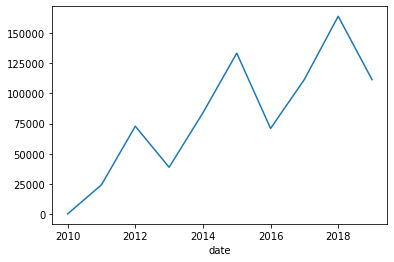

In [370]:
df_vgr['freeCashFlow'].plot()

# HUGE UNPAYABLE AMOUNTS of debt 
# no sign of increasing revenue 
# no ability to aquire greater market share 
# SELL 

# LGORG:: TOOO GOOD 
# done with financing 
# vertically integrating procees 
# buy when chance (0.5-0.6)

# RUTH

In [371]:
dict_ruth_income,errs_ruth = url_import(['RUTH'], 'income-statement')

https://fmpcloud.io/api/v3/income-statement/RUTH?apikey=cb3b0c371586d9ce915d359479fe1c81


In [372]:
df_ruth_income = pd.DataFrame(dict_ruth_income)

In [373]:
df_ruth_income.date = df_ruth_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [374]:
df_ruth_income.set_index(['date'], inplace = True)

In [375]:
dict_ruth_cash,errs_ruth = url_import(['RUTH'], 'cash-flow-statement')
dict_ruth_balance,errs_ruth = url_import(['RUTH'], 'balance-sheet-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/RUTH?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/RUTH?apikey=cb3b0c371586d9ce915d359479fe1c81


In [376]:
df_ruth_cash = pd.DataFrame(dict_ruth_cash)
df_ruth_bal = pd.DataFrame(dict_ruth_balance)

In [377]:
df_ruth_bal.date = df_ruth_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_ruth_cash.date = df_ruth_cash.date.map(lambda x: re.sub(r'-.*$','',x))

In [378]:
df_ruth_bal.set_index(['date'], inplace = True)
df_ruth_cash.set_index(['date'], inplace = True)

In [379]:
df_ruth = pd.concat([df_ruth_income,df_ruth_bal,df_ruth_cash],axis = 1)

In [380]:
df_ruth.drop(['symbol','period'],axis = 1, inplace =True)

In [381]:
df_ruth = df_ruth/1000

In [460]:
df_ruth['shares'] = df_main.loc['RUTH','sharesOutstanding'] /1000

In [383]:
df_ruth[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_ruth[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [384]:
df_ruth = df_ruth.sort_index()

In [385]:
df_ruth_main = df_ruth[['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [386]:
df_ruth_main['netIncome'] = df_ruth_income['netIncome'] / 1000

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# principle 1

# d / e

In [388]:
df_ruth_main['de'] = df_ruth['totalDebt'] / df_ruth['totalStockholdersEquity']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


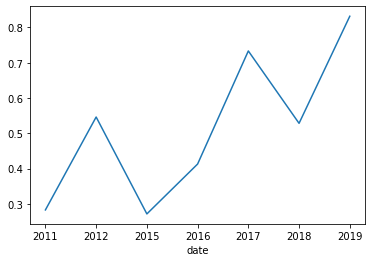

In [389]:
df_ruth_main.de.plot()

In [390]:
df_ruth_main.de

date
2011    0.282838
2012    0.546196
2015    0.271527
2016    0.412890
2017    0.733460
2018    0.528325
2019    0.831834
Name: de, dtype: float64

In [391]:
df_ruth_main.de.mean()

0.5152956447359663

# debt to equity really good and consistent 

# current ratio

In [392]:
df_ruth_main['curr'] = df_ruth['totalCurrentAssets'] / df_ruth['totalCurrentLiabilities']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


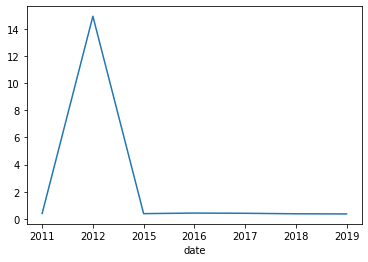

In [393]:
df_ruth_main.curr.plot()

In [396]:
df_ruth_main.curr.values[2:].mean()

0.3996943261024806

# curr ratio: red flag #1

# ROE

In [397]:
df_ruth_main

,netIncomeRatio,totalLiabilities,totalAssets,totalStockholdersEquity,netIncome,de,curr
date,,,,,,,
2011,0.052896,140580.0,240220.0,99640.0,19549.0,0.282838,0.408164
2012,0.041092,148969.0,231357.0,82388.0,16379.0,0.546196,14.921523
2015,0.080346,100695.0,198597.0,97902.0,30004.0,0.271527,0.392747
2016,0.078936,128463.0,207472.0,79009.0,30465.0,0.412890,0.433419
2017,0.072650,162592.0,242096.0,79504.0,30137.0,0.733460,0.418469
2018,0.092144,164481.0,254613.0,90132.0,41680.0,0.528325,0.381665
2019,0.090179,402731.0,496876.0,94145.0,42206.0,0.831834,0.372171


In [398]:
df_ruth_main['roe'] = df_ruth_main['netIncome'] / df_ruth_main['totalStockholdersEquity']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


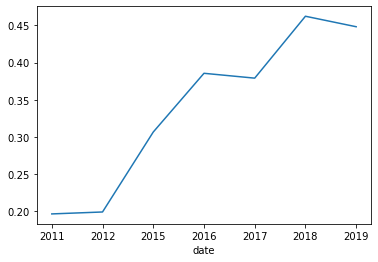

In [399]:
df_ruth_main['roe'].plot()

In [402]:
df_ruth_main['roe']

date
2011    0.196196
2012    0.198803
2015    0.306470
2016    0.385589
2017    0.379063
2018    0.462433
2019    0.448308
Name: roe, dtype: float64

# ROE --> TOO GOOD --> CONSISTENT GROWTH!!

In [403]:
#roi 
df_ruth_main['roi'] = df_ruth_main['netIncome'] / df_ruth_main['totalAssets']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


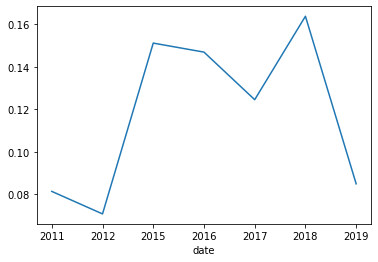

In [404]:
df_ruth_main.roi.plot()

In [405]:
df_ruth_main.roi

date
2011    0.081380
2012    0.070795
2015    0.151080
2016    0.146839
2017    0.124484
2018    0.163699
2019    0.084943
Name: roi, dtype: float64

# Principle 1: 3 of 4 very satisfactory --> look into their ability to pay immediate debt 

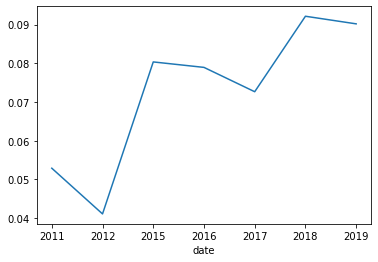

In [409]:
#check earnings inflation
df_ruth_main.netIncomeRatio.plot()

In [411]:
df_ruth_main.netIncomeRatio.pct_change()

date
2011         NaN
2012   -0.223149
2015    0.955259
2016   -0.017558
2017   -0.079627
2018    0.268327
2019   -0.021331
Name: netIncomeRatio, dtype: float64

# principle 3: stable BV growth 
# look at EPS, DIV PAID, BV GROWTH, TOTAL ASSETS AND LIABALITIES  

In [467]:
df_ruth_main['div'] = np.abs(df_ruth['dividendsPaid'])/ df_ruth['shares']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


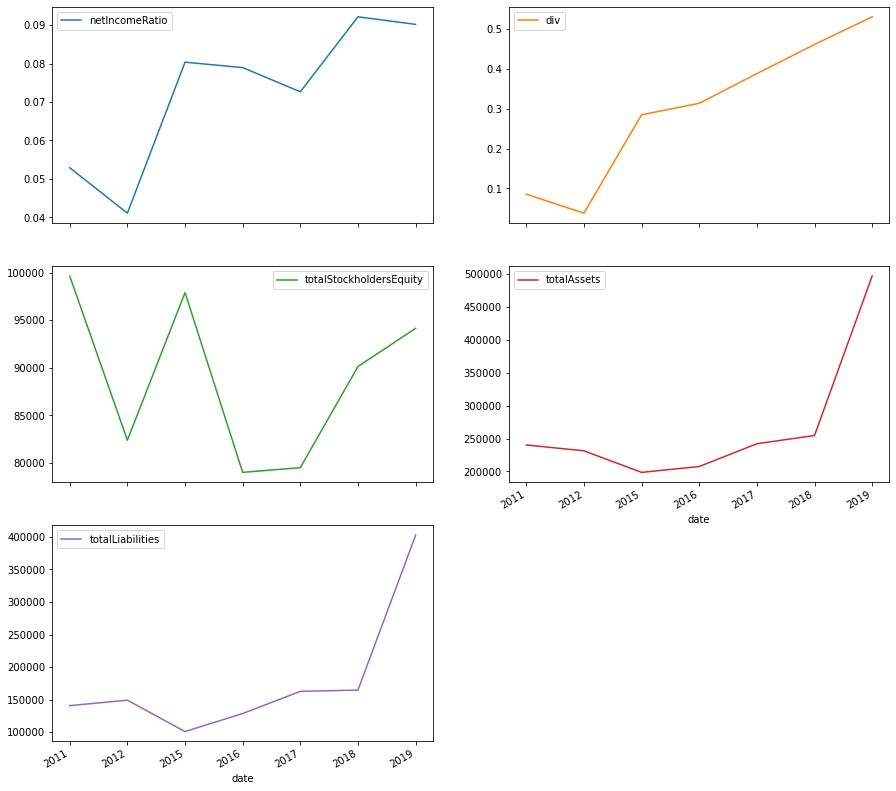

In [468]:
#fig,axs = plt.subplots(2,2,figsize = (10,10))

df_ruth_main[['netIncomeRatio','div','totalStockholdersEquity','totalAssets','totalLiabilities']]\
.plot(subplots = True,figsize = (15,15),layout = (3,-1))
plt.show()

In [438]:
df_ruth_main['div'].pct_change().median()

0.16954330785817417

In [441]:
df_ruth.goodwill

date
2011    22097.0
2012    22097.0
2015    24293.0
2016    24293.0
2017    36522.0
2018    36522.0
2019    45549.0
Name: goodwill, dtype: float64

# Principle 3: very good; minor concern with liabilities 
# but the company has a multitude of franchisies 

# principle 4: 

# p/e and p/b

In [450]:
df_ruth_main['p/e'] = df_main.loc['RUTH','price'] /(df_ruth['eps'])
df_ruth_main['ern_yld'] = 1  / df_ruth_main['p/e']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [469]:
df_ruth_main['p/b'] = df_main.loc['RUTH','price'] / (df_ruth_main['totalStockholdersEquity']/df_ruth['shares'])
df_ruth_main['div_yld'] = df_ruth_main['div'] / df_main.loc['RUTH','price']


/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [454]:
df_ruth_main['p/e'].values[4:].mean()

7.5172957594991985

In [465]:
#p/b and p/s 
df_ruth_main['p/b']

date
2011    2.759691
2012    3.337569
2015    2.808683
2016    3.480308
2017    3.458639
2018    3.050810
2019    2.920767
Name: p/b, dtype: float64

In [470]:
df_ruth_main[['div_yld','ern_yld']]

,div_yld,ern_yld
date,,
2011,0.009092,0.041578
2012,0.004011,-0.061834
2015,0.030363,0.093817
2016,0.033439,0.102345
2017,0.041396,0.105544
2018,0.049193,0.150320
2019,0.056609,0.155650


# price check = perfect 

# inrinsic value 

In [583]:
#1) dcf method 
#get estimate of fcf 
cf_est = df_ruth['freeCashFlow'].mean()
#dr / return 
#use 25 and 20 for dcf and 15 and 20 for 2nd 
dr = 0.20


In [500]:
#det fcf gr
gr = df_ruth['freeCashFlow'].pct_change().mean()
lgr = 0.03 

In [568]:
gr = annual_growth(df_ruth['freeCashFlow'].values[-1],df_ruth['freeCashFlow'].values[0],6)

In [569]:
gr

0.052369429445427995

In [584]:
#calculate 
intrinsic_cash(cf_est,gr,dr,lgr,7) / df_ruth['shares'].values[0]

8.478765591034833

In [585]:
#2) bond method
avg_div = np.abs(df_ruth['dividendsPaid']).mean() / df_ruth['shares'].values[0]
pbv = (df_ruth['totalStockholdersEquity'] / df_ruth['shares']).mean()
bv_yrs = (df_ruth['totalStockholdersEquity'] / df_ruth['shares']).values
bv_gr = annual_growth(bv_yrs[-1],bv_yrs[1],6)

In [604]:
(df_ruth['totalStockholdersEquity'] / df_ruth['shares']).pct_change().median()

0.02539434833262344

In [610]:
np.abs(df_ruth['dividendsPaid']).pct_change().values[3:].mean()

0.16959288170113662

In [613]:
intrinsic_bk(avg_div,pbv,.04, dr,7)

2.1969232732992316

# RUTH DONE for now: buy between 2.6-8.8 with mean of 5.7

# WHD , RUTH, SU, OXY, MIK, TUP

# WHD start 

In [614]:
dict_whd_cash,errs_whd = url_import(['WHD'], 'cash-flow-statement')
dict_whd_balance,errs_whd = url_import(['WHD'], 'balance-sheet-statement')
dict_whd_income,errs_whd = url_import(['WHD'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/WHD?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/WHD?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/WHD?apikey=cb3b0c371586d9ce915d359479fe1c81


In [615]:
df_whd_cash = pd.DataFrame(dict_whd_cash)
df_whd_bal = pd.DataFrame(dict_whd_balance)
df_whd_income = pd.DataFrame(dict_whd_income)

In [616]:
df_whd_bal.date = df_whd_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_whd_cash.date = df_whd_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_whd_income.date = df_whd_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [617]:
df_whd_bal.set_index(['date'], inplace = True)
df_whd_cash.set_index(['date'], inplace = True)
df_whd_income.set_index(['date'], inplace = True)

In [618]:
df_whd = pd.concat([df_whd_income,df_whd_bal,df_whd_cash],axis = 1)

In [619]:
df_whd.drop(['symbol','period'],axis = 1, inplace =True)

In [622]:
df_whd['shares'] = 75.36E06

In [623]:
df_whd = df_whd/1000

In [625]:
df_whd[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_whd[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [626]:
df_whd = df_whd.sort_index()

In [627]:
df_whd_main = df_whd[['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [628]:
df_whd_main['netIncome'] = df_whd_income['netIncome'] / 1000

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# PRINCIPLE 1
# PROBLEM: NOT ENOUGH DATA --> WAY MORE STRICT

# d/e

In [629]:
df_whd_main['de'] = df_whd['totalDebt'] / df_whd['totalStockholdersEquity']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


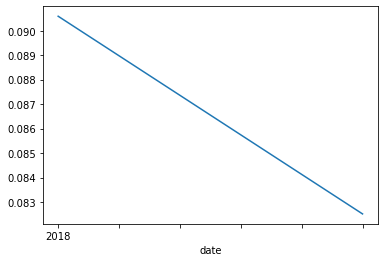

In [630]:
df_whd_main['de'].plot()

In [635]:
df_whd_main.de.mean()

0.08655108391625177

# current ratio

In [636]:
df_whd_main['curr'] = df_whd['totalCurrentAssets'] / df_whd['totalCurrentLiabilities']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


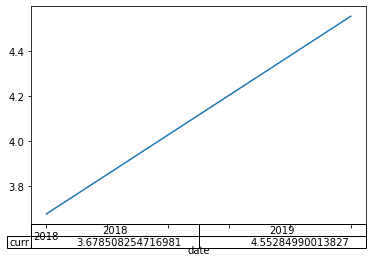

In [638]:
df_whd_main.curr.plot(table = True)

In [639]:
df_whd_main.curr.pct_change()

date
2018         NaN
2019    0.237689
Name: curr, dtype: float64

In [648]:
#check collection speed to make sure no pbs 
df_whd.revenue / df_whd.netReceivables 

date
2018    5.897268
2019    7.152040
dtype: float64

# current ratio too good and accounts recievables in allignment

# ROE

In [649]:
df_whd_main['ROE'] = df_whd_main['netIncome'] / df_whd_main['totalStockholdersEquity']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


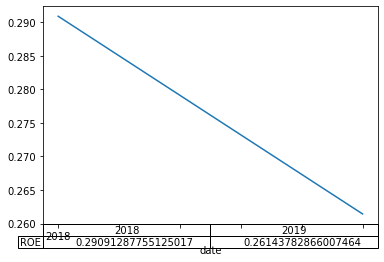

In [651]:
df_whd_main.ROE.plot(table = True)

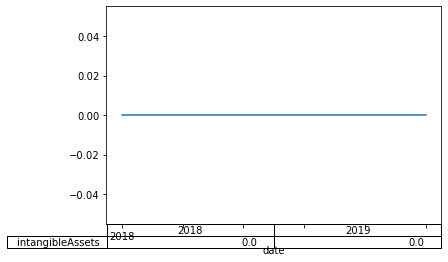

In [653]:
df_whd.intangibleAssets.plot(table = True)

# principle 1: all check  

# principle 3: BV growth 
# total assets, liabilities, eps, div, bv

In [657]:
df_whd.eps

date
2018    1.6
2019    1.9
Name: eps, dtype: float64

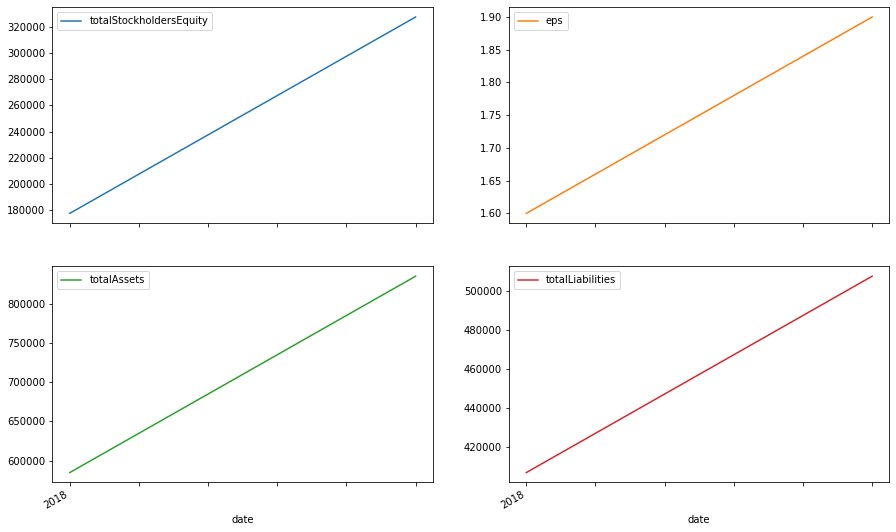

In [658]:

df_whd[['totalStockholdersEquity','eps','totalAssets','totalLiabilities']] \
.plot(subplots = True, layout = (3,-1),figsize = (15,15))
plt.show()

# very very good: they started paying dividends 
# always have double the assets as lioabiolities 
# will not need cash anytime soon 
# investemts rising predictably 

In [659]:
#interest expense 
df_whd.operatingIncome / df_whd.interestExpense

date
2018    49.430042
2019          inf
dtype: float64

# principle 2 and 3 verryy good 

# principle 4

# p/e, p/s , p/b

In [664]:
df_whd_main['pe'] = 15 / df_whd['eps']
df_whd_main['ps'] = 15 / (df_whd['revenue']/ df_whd.shares)
df_whd_main['bv/sh'] = df_whd_main['totalStockholdersEquity'] / df_whd['shares']
df_whd_main['pb'] = 15 / df_whd_main['bv/sh'] 

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [665]:
df_whd_main

,netIncomeRatio,totalLiabilities,totalAssets,totalStockholdersEquity,netIncome,de,curr,ROE,pe,ps,bv/sh,pb
date,,,,,,,,,,,,
2018,0.094982,407086.0,584744.0,177658.0,51683.0,0.090590,3.678508,0.290913,9.375000,2.077426,2.357458,6.362787
2019,0.136235,507498.0,834964.0,327466.0,85612.0,0.082512,4.552850,0.261438,7.894737,1.798814,4.345356,3.451961


In [663]:
annual_growth(327,93,4)

0.36935547020668924

# prices all great 

# INTRINSIC VALUE

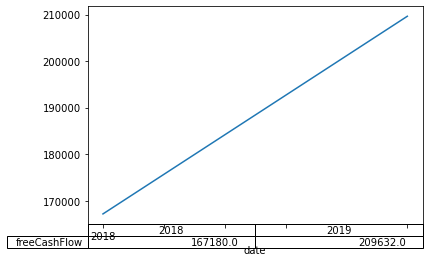

In [666]:
#1 dcf 
#estimating cf 
df_whd['freeCashFlow'].plot(table = True)

In [673]:
df_whd.freeCashFlow.mean()

188406.0

In [674]:
#cf est
cf_est_max = 188406.0
cf_est_min = 54600

In [676]:
annual_growth(150E03, 21E03,5)

0.4817481472042977

In [693]:
#gr
gr_min = 0.15 
gr_max = 0.25
#dr: use ROE
dr = 0.15
lgr = 0.03

In [727]:
shares = df_whd.shares.values[0]
shares

75360.0

In [729]:
dict_iv_whd = intrinsic_cash([cf_est_min,cf_est_max],[0.10,0.15],[0.15,0.2,0.25],lgr,shares,5) 

In [738]:
dict_iv_whd

defaultdict(list,
            {'54.6,10.0%': [7.93956980476473,
              5.415910191393838,
              4.084534111747263],
             '54.6,15.0%': [9.841427813163483,
              6.594644190722331,
              4.8973405902445375],
             '188.406,10.0%': [27.39675070762827,
              18.688461090105264,
              14.094335784942395],
             '188.406,15.0%': [33.959414808917195,
              22.755870575040873,
              16.899054052117446]})

In [736]:
[np.mean(x) for x in dict_iv_whd.values()]

[5.81333803596861, 7.111137531376784, 20.05984919422531, 24.538113145358505]

In [743]:
intrinsic_bk(0.36,3.5,0.10,0.1,5)

4.864683236987042

# WHD DONE: IV= 8-11

# TUP , HONDA, UNDER ARMOR, FORD, GM

# NAH, too uncertain
# FORD

In [863]:
dict_ford_cash,errs_ford = url_import(['F'], 'cash-flow-statement')
dict_ford_balance,errs_ford = url_import(['F'], 'balance-sheet-statement')
dict_ford_income,errs_ford = url_import(['F'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/F?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/F?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/F?apikey=cb3b0c371586d9ce915d359479fe1c81


In [864]:
df_ford_cash = pd.DataFrame(dict_ford_cash)
df_ford_bal = pd.DataFrame(dict_ford_balance)
df_ford_income = pd.DataFrame(dict_ford_income)

In [865]:
df_ford_bal.date = df_ford_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_ford_cash.date = df_ford_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_ford_income.date = df_ford_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [866]:
df_ford_bal.set_index(['date'], inplace = True)
df_ford_cash.set_index(['date'], inplace = True)
df_ford_income.set_index(['date'], inplace = True)

In [867]:
df_ford = pd.concat([df_ford_income,df_ford_bal,df_ford_cash],axis = 1)

In [868]:
df_ford.drop(['symbol','period'],axis = 1, inplace =True)

In [870]:
df_ford['shares'] = 3.977e09

In [871]:
df_ford = df_ford/1000

In [872]:
df_ford[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_ford[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [873]:
df_ford = df_ford.sort_index()

In [874]:
df_ford_main = df_ford[['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [875]:
df_ford_main['netIncome'] = df_ford_income['netIncome'] / 1000

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Principle 1 
# DE

In [876]:
df_ford_main['de'] = df_ford['totalDebt'] / df_ford_main['totalStockholdersEquity']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


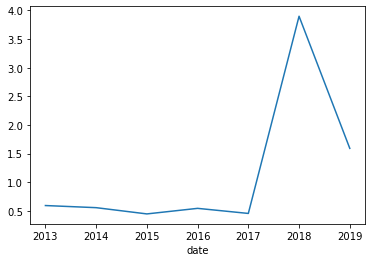

In [877]:
df_ford_main.de.plot()

In [880]:
df_ford_main.de

date
2010         NaN
2013    0.594436
2014    0.557307
2015    0.448258
2016    0.545321
2017    0.456606
2018    3.898085
2019    1.592316
Name: de, dtype: float64

# de was heavily reduced after some incurred mess up 
# pass but careful
# CURRENT

In [881]:
df_ford_main['curr'] = df_ford.totalCurrentAssets / df_ford.totalCurrentLiabilities

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


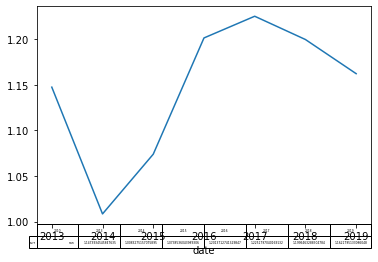

In [882]:
df_ford_main.curr.plot(table = True)

In [884]:
df_ford_main.curr.mean()

1.1454216278543237

# if debt sudddenly rises they will bareley keep up

# ROE

In [885]:
df_ford_main['roe'] = df_ford_main['netIncome'] /df_ford_main.totalStockholdersEquity

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


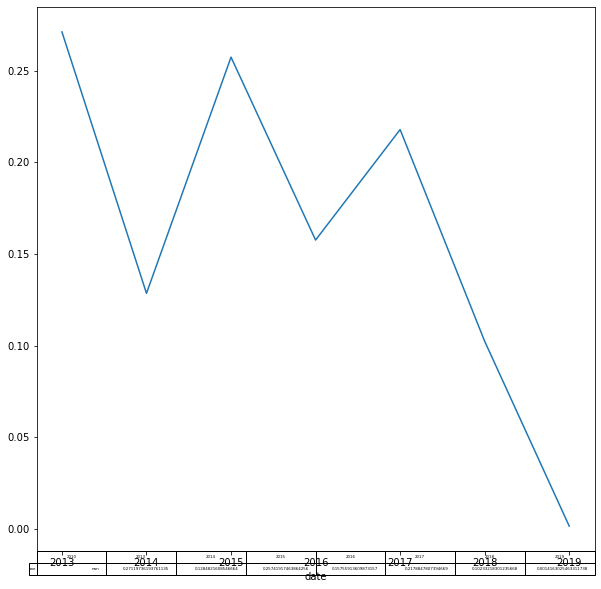

In [886]:
df_ford_main.roe.plot(figsize = (10,10),table = True)

In [888]:
df_ford_main.roe.mean()

0.16232729997540093

In [891]:
df_ford_main[['netIncome','totalStockholdersEquity']].pct_change()

,netIncome,totalStockholdersEquity
date,,
2010,NaN,NaN
2013,inf,inf
2014,-0.554577,-0.059811
2015,1.313461,0.154687
2016,-0.376645,0.018434
2017,0.654047,0.196092
2018,-0.516311,0.029865
2019,-0.987218,-0.076450


# ROE is consistetn
# had a bad year 
# earnings dropped by 90%!

In [894]:
df_ford

,fillingDate,revenue,costOfRevenue,grossProfit,grossProfitRatio,researchAndDevelopmentExpenses,generalAndAdministrativeExpenses,sellingAndMarketingExpenses,otherExpenses,operatingExpenses,costAndExpenses,interestExpense,depreciationAndAmortization,ebitda,ebitdaratio,operatingIncome,operatingIncomeRatio,totalOtherIncomeExpensesNet,incomeBeforeTax,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink,fillingDate,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,goodwill,intangibleAssets,goodwillAndIntangibleAssets,longTermInvestments,taxAssets,otherNonCurrentAssets,totalNonCurrentAssets,otherAssets,totalAssets,accountPayables,shortTermDebt,taxPayables,deferredRevenue,otherCurrentLiabilities,totalCurrentLiabilities,longTermDebt,deferredRevenueNonCurrent,deferrredTaxLiabilitiesNonCurrent,otherNonCurrentLiabilities,totalNonCurrentLiabilities,otherLiabilities,totalLiabilities,commonStock,retainedEarnings,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalLiabilitiesAndStockholdersEquity,totalInvestments,totalDebt,netDebt,link,finalLink,fillingDate,netIncome,depreciationAndAmortization,deferredIncomeTax,stockBasedCompensation,changeInWorkingCapital,accountsReceivables,inventory,accountsPayables,otherWorkingCapital,otherNonCashItems,netCashProvidedByOperatingActivites,investmentsInPropertyPlantAndEquipment,acquisitionsNet,purchasesOfInvestments,salesMaturitiesOfInvestments,otherInvestingActivites,netCashUsedForInvestingActivites,debtRepayment,commonStockIssued,commonStockRepurchased,dividendsPaid,otherFinancingActivites,netCashUsedProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow,link,finalLink,shares
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010,NaN,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.00000,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,3977000.0
2013,NaN,146917000.0,125234000.0,21683000.0,0.147587,6400000.0,13176000.0,0.0,132010000.0,151586000.0,141478000.0,3689000.0,0.0,7001000.0,0.047653,7001000.0,0.047653,0.0,7001000.0,0.047653,-147000.0,7155000.0,0.048701,1.82,0.00176,3935000.0,4087000.0,NaN,NaN,NaN,14468000.0,20157000.0,34625000.0,77481000.0,7708000.0,-77357000.0,42457000.0,27616000.0,0.0,0.0,0.0,22100000.0,13283000.0,96570000.0,159569000.0,0.0,202026000.0,18035000.0,1257000.0,0.0,0.0,17711000.0,37003000.0,14426000.0,0.0,430000.0,21665000.0,36521000.0,102119000.0,175643000.0,39000.0,23658000.0,-18231000.0,20917000.0,26383000.0,202026000.0,42257000.0,15683000.0,1215000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,5454000.0,0.0,0.0,0.0,5454000.0,0.0,10444000.0,-6597000.0,0.0,-120206000.0,118247000.0,4447000.0,-4109000.0,-25026000.0,0.0,-213000.0,-1574000.0,34946000.0,8133000.0,-37000.0,14468000.0,14468000.0,0.0,10444000.0,6597000.0,3847000.0,NaN,NaN,3977000.0
2014,NaN,144077000.0,123516000.0,20561000.0,0.142708,6900000.0,14117000.0,0.0,130733000.0,151750000.0,140637000.0,3496000.0,7423000.0,11765000.0,0.081658,4342000.0,0.030137,0.0,4342000.0,0.030137,1156000.0,3187000.0,0.022120,0.81,0.00080,3912000.0,4045000.0,NaN,NaN,NaN,10757000.0,17135000.0,21702000.0,81111000.0,7866000.0,-76427000.0,40442000.0,30126000.0,0.0,0.0,0.0,20393000.0,13331000.0,104235000.0,168085000.0,0.0,208527000.0,18876000.0,2501000.0,0.0,0.0,18731000.0,40108000.0,11323000.0,0.0,367000.0,23793000.0,35483000.0,

In [897]:
# a lot of restructuring costs 
#pay attention to debt
df_ford.operatingIncome / df_ford.interestExpense

date
2010         NaN
2013    1.897804
2014    1.241991
2015    3.176945
2016    7.601790
2017    7.191527
2018    3.710504
2019    0.106119
dtype: float64

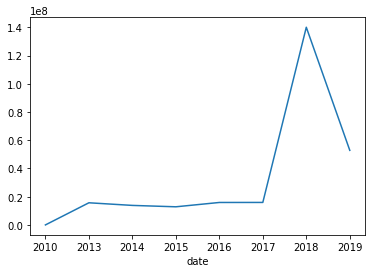

In [900]:
df_ford['totalDebt'].plot()

# principle 3: BV, DEBT, LIABILITIES, ASSETS, EPS,DIV

In [901]:
df_ford_main['totalDebt'] = df_ford.totalDebt

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [902]:
df_ford_main['bv'] = df_ford_main['totalStockholdersEquity'] / df_ford.shares

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [905]:
df_ford_main['eps'] = df_ford['eps']
df_ford_main['div'] = np.abs(df_ford['dividendsPaid']) /df_ford.shares

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [912]:
df_ford_main.eps

date
2010    0.00
2013    1.82
2014    0.81
2015    1.86
2016    1.16
2017    1.91
2018    0.93
2019    0.01
Name: eps, dtype: float64

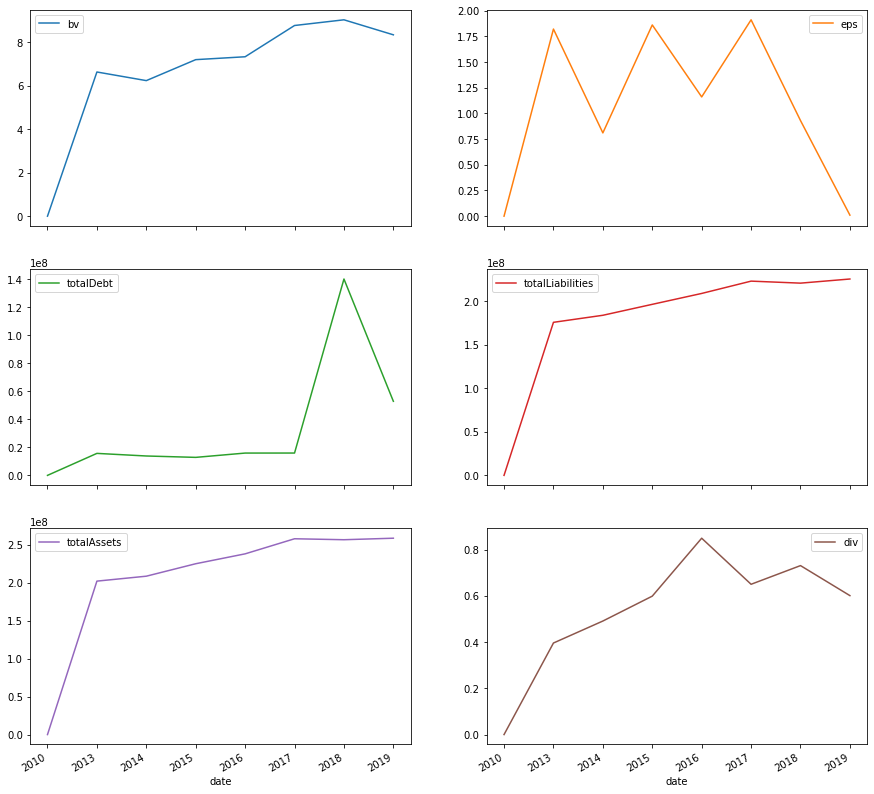

In [914]:
df_ford_main[['bv','eps','totalDebt','totalLiabilities','totalAssets','div']] \
.plot(subplots = True, figsize = (15,15),layout = (3,-1))
plt.show()

In [915]:
df_ford['totalAssets'] / df_ford['totalLiabilities']

date
2010         NaN
2013    1.150208
2014    1.135014
2015    1.145922
2016    1.139716
2017    1.156515
2018    1.162877
2019    1.147259
dtype: float64

In [916]:
df_ford['roa'] = df_ford_main['netIncome'] / df_ford_main['totalAssets']

In [917]:
df_ford.roa

date
2010         NaN
2013    0.035416
2014    0.015283
2015    0.032780
2016    0.019315
2017    0.029487
2018    0.014333
2019    0.000182
Name: roa, dtype: float64

# principle 3: pass

# principle 4: 
# pe,ps,pb

In [920]:
df_ford_main['pe'] = 5 / df_ford_main['eps']
df_ford_main['ps'] = 5 / (df_ford['revenue'] / df_ford.shares)
df_ford_main['pb'] = 5 / df_ford_main['bv']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [931]:
df_ford_main[['pe','ps','pb','bv','div']]

,pe,ps,pb,bv,div
date,,,,,
2010,inf,inf,inf,0.000000,0.000000
2013,2.747253,0.135349,0.753705,6.633895,0.395776
2014,6.172840,0.138016,0.801653,6.237113,0.490822
2015,2.688172,0.132958,0.694260,7.201911,0.598441
2016,4.310345,0.130995,0.681694,7.334674,0.848881
2017,2.617801,0.126837,0.569934,8.772944,0.649736
2018,5.376344,0.124019,0.553406,9.034951,0.730450
2019,500.000000,0.127550,0.599217,8.344229,0.600704


In [932]:
df_ford_main['div'].median()

0.5995725421171738

# Ratios / price --> too good 

# other ratios

In [933]:
# efficiency which will be vital 
df_ford.costOfRevenue / df_ford.inventory.iloc[:,0]

date
2010          NaN
2013    16.247276
2014    15.702517
2015    14.910566
2016    14.226118
2017    12.779216
2018    12.145187
2019    12.487762
dtype: float64

In [934]:
# accts payable 
df_ford.costOfRevenue / df_ford.accountPayables

date
2010         NaN
2013    6.943942
2014    6.543547
2015    6.471254
2016    5.944027
2017    5.640924
2018    6.332203
2019    6.515407
dtype: float64

In [936]:
#laib_to_eq
df_ford.totalLiabilities, df_ford.totalStockholdersEquity

(date
 2010            0.0
 2013    175643000.0
 2014    183722000.0
 2015    196283000.0
 2016    208781000.0
 2017    222918000.0
 2018    220608000.0
 2019    225352000.0
 Name: totalLiabilities, dtype: float64,
 date
 2010           0.0
 2013    26383000.0
 2014    24805000.0
 2015    28642000.0
 2016    29170000.0
 2017    34890000.0
 2018    35932000.0
 2019    33185000.0
 Name: totalStockholdersEquity, dtype: float64)

In [938]:
#maintanance / future grwoth --> the bet
np.abs(df_ford.netCashUsedForInvestingActivites) / df_ford.netCashProvidedByOperatingActivites

date
2010         NaN
2013    0.393432
2014    1.456125
2015    1.617934
2016    1.280922
2017    0.165672
2018    0.121023
2019    0.777879
dtype: float64

In [941]:
df_ford[['netCashUsedForInvestingActivites','netCashProvidedByOperatingActivites','operatingCashFlow']]

,netCashUsedForInvestingActivites,netCashProvidedByOperatingActivites,operatingCashFlow
date,,,
2010,0.0,0.0,0.0
2013,-4109000.0,10444000.0,10444000.0
2014,-21124000.0,14507000.0,14507000.0
2015,-26162000.0,16170000.0,16170000.0
2016,-25352000.0,19792000.0,19792000.0
2017,-2998000.0,18096000.0,18096000.0
2018,1818000.0,15022000.0,15022000.0
2019,-13721000.0,17639000.0,17639000.0


In [962]:
df_ford.freeCashFlow.median()

8105500.0

# valuation

In [966]:
#DCF 
# finding cash flowwwwwwww
cf_ests_frd = [df_ford.freeCashFlow.mean(),df_ford.freeCashFlow.median()]
grs = [0.05,0.12, 0.17]
drs = [0.15,0.20,0.25]
lgr = 0.03

In [967]:
dict_ivs = intrinsic_cash(cf_ests_frd,grs,drs,lgr,df_ford.shares.values[0],7)

In [968]:
intrn_avg(dict_ivs)

defaultdict(float,
            {'7619.5,5.0%': 12.954989347047528,
             '7619.5,12.0%': 18.310286044736753,
             '7619.5,17.0%': 23.512498035803574,
             '8105.5,5.0%': 13.781306667431423,
             '8105.5,12.0%': 19.478184071870043,
             '8105.5,17.0%': 25.012212458718533})

In [976]:
df_ford_main.bv.pct_change().median()

0.029865290914302012

In [981]:
df_ford_main.bv

date
2010    0.000000
2013    6.633895
2014    6.237113
2015    7.201911
2016    7.334674
2017    8.772944
2018    9.034951
2019    8.344229
Name: bv, dtype: float64

In [983]:
annual_growth(df_ford_main.bv.values[-1],df_ford_main.bv.values[1],6)

0.03896984009552673

In [987]:
#2) intrinsic bk
intrinsic_bk(0.56,7.268,0.03,0.1,7 )

7.313292942268507

# FORD MUST BUY A LOTTTT
# IV = 7-23

# OXY

In [988]:
dict_oxy_cash,errs_oxy = url_import(['OXY'], 'cash-flow-statement')
dict_oxy_balance,errs_oxy = url_import(['OXY'], 'balance-sheet-statement')
dict_oxy_income,errs_oxy = url_import(['OXY'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/OXY?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/OXY?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/OXY?apikey=cb3b0c371586d9ce915d359479fe1c81


In [989]:
df_oxy_cash = pd.DataFrame(dict_oxy_cash)
df_oxy_bal = pd.DataFrame(dict_oxy_balance)
df_oxy_income = pd.DataFrame(dict_oxy_income)

In [990]:
df_oxy_bal.date = df_oxy_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_oxy_cash.date = df_oxy_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_oxy_income.date = df_oxy_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [991]:
df_oxy_bal.set_index(['date'], inplace = True)
df_oxy_cash.set_index(['date'], inplace = True)
df_oxy_income.set_index(['date'], inplace = True)

In [992]:
df_oxy = pd.concat([df_oxy_income,df_oxy_bal,df_oxy_cash],axis = 1)

In [993]:
df_oxy.drop(['symbol','period'],axis = 1, inplace =True)

In [995]:
df_oxy['shares'] = df_main.loc['OXY','sharesOutstanding']

In [996]:
df_oxy = df_oxy/1000

In [997]:
df_oxy[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_oxy[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [998]:
df_oxy = df_oxy.sort_index()

In [999]:
df_oxy_main = df_oxy[['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [1000]:
df_oxy_main['netIncome'] = df_oxy_income['netIncome'] / 1000

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# PRINCIPLE 1: 
# de

In [1001]:
df_oxy_main['de'] = df_oxy['totalLiabilities'] / df_oxy.totalStockholdersEquity

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


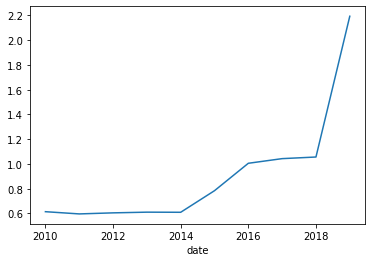

In [1002]:
df_oxy_main.de.plot()

In [1004]:
df_oxy_main.de.mean()

0.9116137839915446

# DE a little high but understandable 
# current

In [1005]:
df_oxy_main['curr'] = df_oxy['totalCurrentAssets'] / df_oxy.totalCurrentLiabilities

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


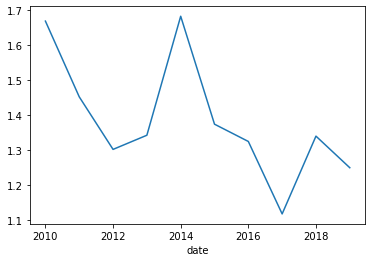

In [1006]:
df_oxy_main.curr.plot()

In [1009]:
df_oxy_main.curr.mean()

1.385475890019266

# current is great 
# ROE

In [1010]:
df_oxy_main['roe'] = df_oxy_main.netIncome / df_oxy.totalStockholdersEquity

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


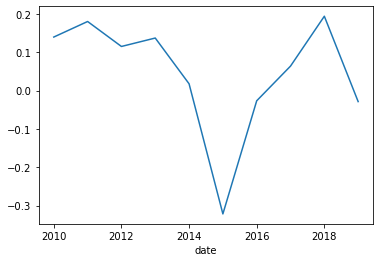

In [1011]:
df_oxy_main.roe.plot()

In [1016]:
df_oxy_main.roe.median()

0.08931571742292778

In [1013]:
df_oxy_main[['netIncome','totalStockholdersEquity']]

,netIncome,totalStockholdersEquity
date,,
2010,4530000.0,32484000.0
2011,6771000.0,37620000.0
2012,4598000.0,40016000.0
2013,5903000.0,43126000.0
2014,616000.0,34959000.0
2015,-7829000.0,24350000.0
2016,-574000.0,21497000.0
2017,1311000.0,20572000.0
2018,4131000.0,21330000.0


# equity tooo good 
# not being used for earnings though

In [1017]:
df_oxy_main['netIncome'] / df_oxy_main['totalAssets']

date
2010    0.086398
2011    0.112767
2012    0.071609
2013    0.085005
2014    0.010949
2015   -0.180238
2016   -0.013315
2017    0.031195
2018    0.094199
2019   -0.009009
dtype: float64

# principle 2,3 tooo good 
# bv, totalAss,totalLiab,div,eps

In [1018]:
df_oxy_main['eps'] = df_oxy.eps

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1019]:
df_oxy_main['bv'] = df_oxy.totalStockholdersEquity / df_oxy.shares

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1020]:
df_oxy_main['div'] = np.abs(df_oxy.dividendsPaid) / df_oxy.shares

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1023]:
df_oxy_main.bv.pct_change().mean()

0.032022036122470815

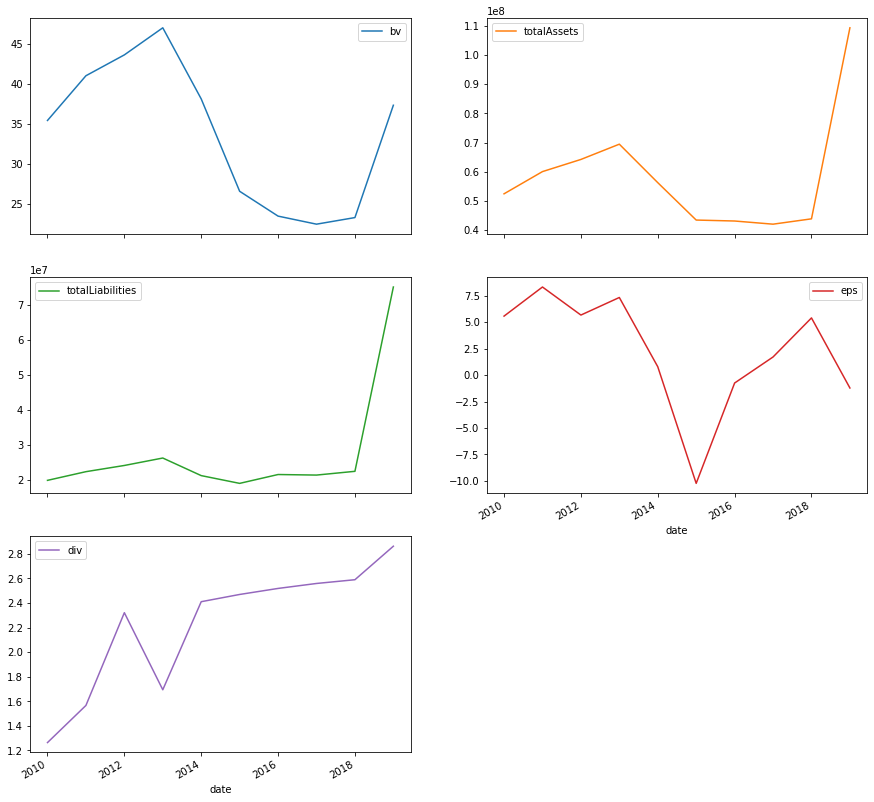

In [1029]:
df_oxy_main[['bv','totalAssets','totalLiabilities','eps','div']]\
.plot(subplots = True,figsize = (15,15), layout = (3,-1))
df_oxy.revenue.plot()
plt.show()

# consistent stable growth 
# omg dat div growth --> toooo good 

# principle 4
# pe,ps,pb,other ratios

In [1035]:
df_oxy_main['pe'] = 15 / df_oxy_main['eps']
df_oxy_main['ps'] = 15 / (df_oxy.revenue/ df_oxy.shares)
df_oxy_main['pb'] = 15 / df_oxy_main.bv

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [1033]:
df_oxy_main.pe.mean()

0.5963461933336465

In [1037]:
df_oxy_main.ps.mean()

0.814989898753768

In [1039]:
df_oxy_main.pb.mean()

0.47641124903299853

In [1045]:
df_oxy_main['div'].mean()

2.225513888969364

# cf analysis

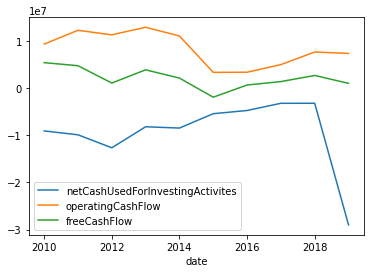

In [1046]:
df_oxy[['netCashUsedForInvestingActivites','operatingCashFlow','freeCashFlow']].plot()

# valuation

In [1073]:
#1) DCF
#cf est
cf_ests_oxy = [df_oxy.freeCashFlow.median(),df_oxy.freeCashFlow.mean()]

In [1069]:
df_oxy.freeCashFlow

date
2010    5409000.0
2011    4763000.0
2012    1086000.0
2013    3890000.0
2014    2138000.0
2015   -1921000.0
2016     666000.0
2017    1397000.0
2018    2694000.0
2019    1020000.0
Name: freeCashFlow, dtype: float64

In [1072]:
#grs 
annual_growth(df_oxy.freeCashFlow.values[-1],df_oxy.freeCashFlow.values[6],4)

0.11245252382535553

In [1077]:
grs = [0.06,0.1,0.15]
drs =[0.15,0.20,0.25]
lgr = 0.03


In [1080]:
intrinsic_cash(cf_ests_oxy,grs,drs,lgr,df_oxy.shares.values[0],9)

defaultdict(list,
            {'1767.5,6.0%': [19.127232242678485,
              13.196243256208833,
              10.052612951584923],
             '1767.5,10.0%': [24.594840037439248,
              16.409200447655763,
              12.17766840381772],
             '1767.5,15.0%': [33.89978244771835,
              21.7426287967259,
              15.62385785807119],
             '2114.2,6.0%': [22.879091602529478,
              15.784722767907617,
              12.024460708481381],
             '2114.2,10.0%': [29.419185746621814,
              19.627910374219976,
              14.566351648855118],
             '2114.2,15.0%': [40.54931827494548,
              26.007505404264727,
              18.688520669609115]})

In [1081]:
intrn_avg(dict_ivs)

defaultdict(float,
            {'1767.5,6.0%': 13.920344367840473,
             '1767.5,10.0%': 17.222714555519673,
             '1767.5,15.0%': 22.595449328938244,
             '2114.2,6.0%': 16.650858309752945,
             '2114.2,10.0%': 20.600997518121464,
             '2114.2,15.0%': 27.027609036062938})

In [1083]:
df_oxy_main.bv

date
2010    35.432825
2011    41.035060
2012    43.648563
2013    47.040882
2014    38.132500
2015    26.560439
2016    23.448450
2017    22.439480
2018    23.266290
2019    37.339505
Name: bv, dtype: float64

In [1085]:
annual_growth(37.339505,26.560439,10)

0.03464968708270266

In [1086]:
df_oxy_main['div'].mean()

2.225513888969364

In [1091]:
intrinsic_bk(2.225513888969364, 37.5,0.03,0.15,10)

23.626673355382483

# must do mtdr, mmlp,kos,NBLX,ICD

# NBLX STRAT 

In [1092]:
dict_nblx_cash,errs_nblx = url_import(['NBLX'], 'cash-flow-statement')
dict_nblx_balance,errs_nblx = url_import(['NBLX'], 'balance-sheet-statement')
dict_nblx_income,errs_nblx = url_import(['NBLX'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/NBLX?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/NBLX?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/NBLX?apikey=cb3b0c371586d9ce915d359479fe1c81


In [1093]:
df_nblx_cash = pd.DataFrame(dict_nblx_cash)
df_nblx_bal = pd.DataFrame(dict_nblx_balance)
df_nblx_income = pd.DataFrame(dict_nblx_income)

In [1094]:
df_nblx_bal.date = df_nblx_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_nblx_cash.date = df_nblx_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_nblx_income.date = df_nblx_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [1095]:
df_nblx_bal.set_index(['date'], inplace = True)
df_nblx_cash.set_index(['date'], inplace = True)
df_nblx_income.set_index(['date'], inplace = True)

In [1096]:
df_nblx = pd.concat([df_nblx_income,df_nblx_bal,df_nblx_cash],axis = 1)

In [1097]:
df_nblx.drop(['symbol','period'],axis = 1, inplace =True)

In [1099]:
df_nblx['shares'] = 90.24E06

In [1100]:
df_nblx = df_nblx/1000

In [1101]:
df_nblx[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_nblx[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [1102]:
df_nblx = df_nblx.sort_index()

In [1103]:
df_nblx_main = df_nblx[['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [1104]:
df_nblx_main['netIncome'] = df_nblx_income['netIncome'] / 1000

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Principle 1
# DE

In [1105]:
df_nblx_main['de'] = df_nblx['totalDebt']/df_nblx['totalStockholdersEquity']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


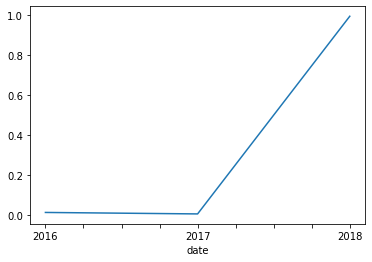

In [1106]:
df_nblx_main.de.plot()

In [1109]:
df_nblx_main.de.mean()

0.33795203712526095

In [1119]:
#grs 
#debt growth
annual_growth(559568238,4786,3)

47.8982654309774

In [1118]:
df_nblx['totalDebt']

date
2016      4786.0
2017      3142.0
2018    568238.0
Name: totalDebt, dtype: float64

In [1120]:
#eqiuity growht 
annual_growth(814,264,4)

0.32511972747451123

# DE pass
# current

In [1110]:
df_nblx_main['curr'] = df_nblx['totalCurrentAssets'] / df_nblx['totalCurrentLiabilities']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


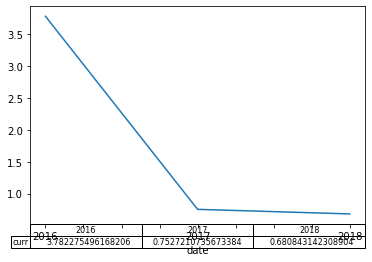

In [1111]:
df_nblx_main.curr.plot(table = True)

In [1112]:
df_nblx_main.curr.mean()

1.7386132373481493

In [1113]:
#compare current ass gr with curr liab
#where thecompany is headed 
annual_growth(108,40,4)

0.2818610191887023

In [1114]:
annual_growth(128,24,4)

0.5196713713031851

# rf #1: curr liab growing way faster than assets
# ROE

In [1121]:
df_nblx_main['roe'] = df_nblx_main['netIncome'] / df_nblx_main['totalStockholdersEquity']

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


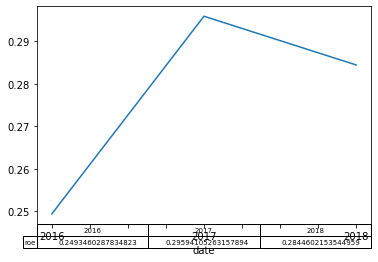

In [1122]:
df_nblx_main['roe'].plot(table = True)

In [1123]:
df_nblx.netIncome

,netIncome,netIncome
date,,
2016,85502.0,85502.0
2017,140572.0,163636.0
2018,162734.0,188876.0


In [1124]:
annual_growth(160,38,4)

0.4324652540883176

# ROE: passs --> very good at generating more earnings 

# growth rates

In [1125]:
#total ass vs total liab
annual_growth(2926,305,4), annual_growth(2112,42,4)

(0.7599228119525248, 1.6629386180352235)

In [1128]:
df_nblx.operatingIncome / df_nblx.interestExpense

date
2016    33.393715
2017    99.142233
2018    17.470454
dtype: float64

In [1127]:
#operating income vs interest
annual_growth(283,61,4), annual_growth(34,5,4)

(0.46762178649070685, 0.6148315584236825)

In [1129]:
#ocf vs netincome
annual_growth(385,69,4)

0.5369258305749234

# growth rates all good excpet for long term debt 
# principle 1: good 
# principle 3: BV gorwth 

In [1130]:
df_nblx_main['bv'] = df_nblx.totalStockholdersEquity / df_nblx.shares

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1131]:
df_nblx_main['div'] = np.abs(df_nblx.dividendsPaid) / df_nblx.shares

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1132]:
df_nblx_main['eps'] = df_nblx.eps

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1135]:
df_nblx_main['bv'].mean()

5.134400856973994

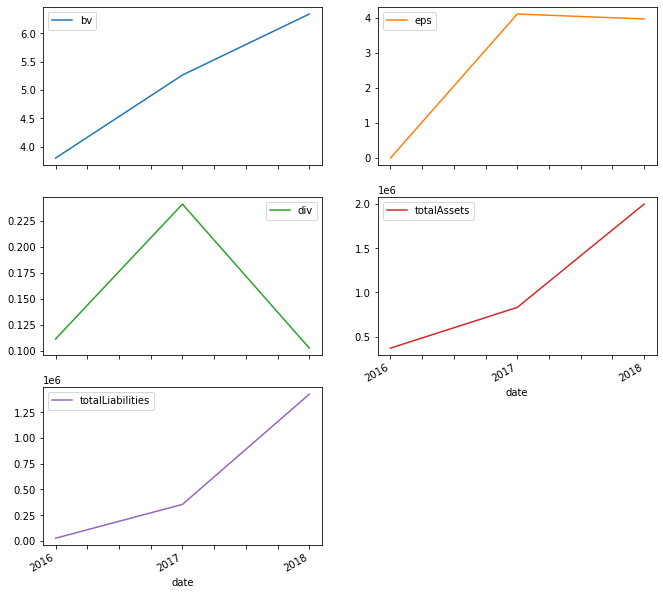

In [1144]:
df_nblx_main[['bv','eps','div','totalAssets','totalLiabilities']] \
.plot(subplots = True,layout = (3,-1),figsize = (11,11))
plt.show()

In [1148]:
annual_growth(116,42,3)

0.40303842844467863

# principle 2,3 good

# principle 4: 
# cash flow

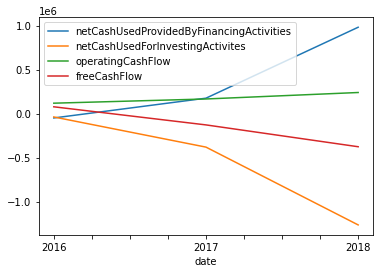

In [1149]:
df_nblx[['netCashUsedProvidedByFinancingActivities','netCashUsedForInvestingActivites','operatingCashFlow','freeCashFlow']] \
.plot()

# valuation


In [1158]:
#cf
cf_ests = [123E03,42E03]
grs=[0.1,0.15,0.2]
drs = [0.2,0.25]
lgr = 0.03 


In [1159]:
dict_ivs_nblx = intrinsic_cash(cf_ests, grs,drs,lgr,df_nblx.shares.values[0],4)

In [1161]:
intrn_avg(dict_ivs_nblx)

defaultdict(float,
            {'123.0,10.0%': 8.560533785237231,
             '123.0,15.0%': 10.117091331676853,
             '123.0,20.0%': 11.92103133659802,
             '42.0,10.0%': 2.923109097398079,
             '42.0,15.0%': 3.4546165522799006,
             '42.0,20.0%': 4.070596066155421})

In [1165]:
intrinsic_bk(0.9,6,0.1,0.005,4)

12.16652847290263

# nblx done: keep until 10-13
# mmlp

In [1166]:
dict_mmlp_cash,errs_mmlp = url_import(['MMLP'], 'cash-flow-statement')
dict_mmlp_balance,errs_mmlp = url_import(['MMLP'], 'balance-sheet-statement')
dict_mmlp_income,errs_mmlp = url_import(['MMLP'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/MMLP?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/MMLP?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/MMLP?apikey=cb3b0c371586d9ce915d359479fe1c81


In [1167]:
df_mmlp_cash = pd.DataFrame(dict_mmlp_cash)
df_mmlp_bal = pd.DataFrame(dict_mmlp_balance)
df_mmlp_income = pd.DataFrame(dict_mmlp_income)

In [1168]:
df_mmlp_bal.date = df_mmlp_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_mmlp_cash.date = df_mmlp_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_mmlp_income.date = df_mmlp_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [1169]:
df_mmlp_bal.set_index(['date'], inplace = True)
df_mmlp_cash.set_index(['date'], inplace = True)
df_mmlp_income.set_index(['date'], inplace = True)

In [1170]:
df_mmlp = pd.concat([df_mmlp_income,df_mmlp_bal,df_mmlp_cash],axis = 1)

In [1171]:
df_mmlp.drop(['symbol','period'],axis = 1, inplace =True)

In [1172]:
df_mmlp['shares'] = 38.66E06

In [1173]:
df_mmlp = df_mmlp/1000

In [1174]:
df_mmlp[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_mmlp[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [1175]:
df_mmlp = df_mmlp.sort_index()

In [1176]:
df_mmlp_main = df_mmlp[['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [1177]:
df_mmlp_main['netIncome'] = df_mmlp_income['netIncome'] / 1000

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# PRIN 1
# DE

In [1178]:
df_mmlp_main['de'] = df_mmlp.totalDebt / df_mmlp.totalStockholdersEquity

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


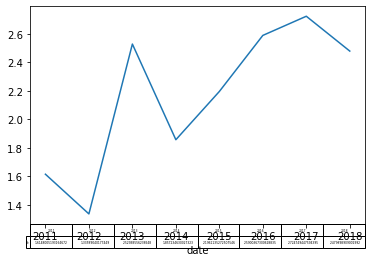

In [1180]:
df_mmlp_main.de.plot(table = True)

In [1182]:
df_mmlp_main.de.mean()

2.1660137159269732

In [1185]:
annual_growth(df_mmlp.totalStockholdersEquity.values[-1],df_mmlp.totalStockholdersEquity.values[0],7)

-0.010489122764056225

In [1184]:
df_mmlp.totalDebt

date
2011    460202.0
2012    478198.0
2013    658695.0
2014    902005.0
2015    865003.0
2016    808107.0
2017    812632.0
2018    656459.0
Name: totalDebt, dtype: float64

# CURRENT: WITH THE TERRIBLE SITUATION CAN THEY KEEP AFLOAT UNTIL PAYMNET

In [1186]:
df_mmlp_main['curr'] = df_mmlp.totalCurrentAssets /df_mmlp.totalCurrentLiabilities

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


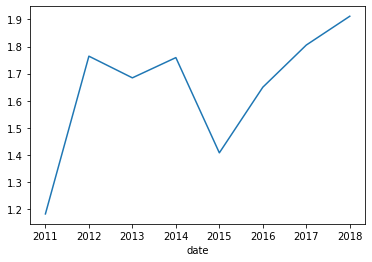

In [1187]:
df_mmlp_main.curr.plot()

In [1189]:
df_mmlp_main.curr.mean()

1.645837658739829

In [1191]:
annual_growth(df_mmlp.totalCurrentLiabilities.values[-1],df_mmlp.totalCurrentLiabilities.values[0],7)

-0.08924645959879884

In [ ]:
df_mmlp.

# CURR IS GOOD 

# roe

In [1192]:
df_mmlp_main['roe'] = df_mmlp_main.netIncome / df_mmlp.totalStockholdersEquity

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


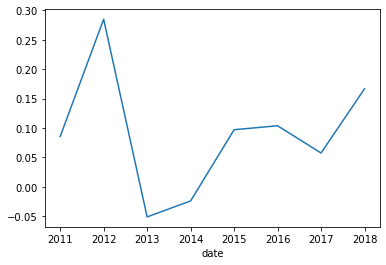

In [1193]:
df_mmlp_main.roe.plot()

In [1196]:
df_mmlp_main.roe

date
2011    0.085414
2012    0.284910
2013   -0.051279
2014   -0.024101
2015    0.097017
2016    0.103774
2017    0.057454
2018    0.166615
Name: roe, dtype: float64

In [1197]:
df_mmlp_main['bv'] = df_mmlp.totalStockholdersEquity /df_mmlp.shares

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


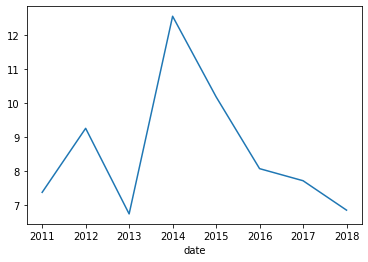

In [1200]:
df_mmlp_main.bv.plot()

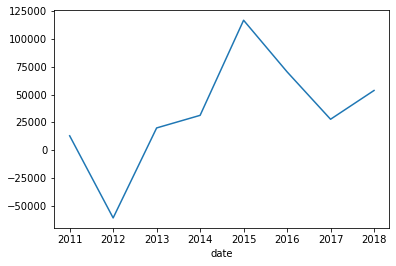

In [1202]:
df_mmlp.freeCashFlow.plot()

In [1206]:
annual_growth(df_mmlp.freeCashFlow.values[-1], df_mmlp.freeCashFlow.values[0], 6)

0.2684671823501641

In [1207]:
cf_est = [33961.75]
gr = [0.1]
drs = [0.15,0.2,0.25]

In [1208]:
intrinsic_cash(cf_est,gr,drs,0.03,df_mmlp.shares.values[0],6)

defaultdict(list,
            {'33.96175,10.0%': [10.048340958001406,
              6.824751737497709,
              5.13120069179683]})

In [1210]:
df_mmlp.dividendsPaid

date
2011    0.0
2012    0.0
2013    0.0
2014    0.0
2015    0.0
2016    0.0
2017    0.0
2018    0.0
Name: dividendsPaid, dtype: float64

In [1211]:
intrinsic_bk(0.25,6,0.05,0.0025,6)

9.407975575548537

# keep and sell at 6-7

# MTDR

In [1212]:
dict_mtd_cash,errs_mtd = url_import(['MTDR'], 'cash-flow-statement')
dict_mtd_balance,errs_mtd = url_import(['MTDR'], 'balance-sheet-statement')
dict_mtd_income,errs_mtd = url_import(['MTDR'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/MTDR?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/MTDR?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/MTDR?apikey=cb3b0c371586d9ce915d359479fe1c81


In [1213]:
df_mtd_cash = pd.DataFrame(dict_mtd_cash)
df_mtd_bal = pd.DataFrame(dict_mtd_balance)
df_mtd_income = pd.DataFrame(dict_mtd_income)

In [1214]:
df_mtd_bal.date = df_mtd_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_mtd_cash.date = df_mtd_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_mtd_income.date = df_mtd_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [1215]:
df_mtd_bal.set_index(['date'], inplace = True)
df_mtd_cash.set_index(['date'], inplace = True)
df_mtd_income.set_index(['date'], inplace = True)

In [1216]:
df_mtd = pd.concat([df_mtd_income,df_mtd_bal,df_mtd_cash],axis = 1)

In [1217]:
df_mtd.drop(['symbol','period'],axis = 1, inplace =True)

In [1218]:
df_mtd['shares'] = 116E06

In [1219]:
df_mtd = df_mtd/1000

In [1220]:
df_mtd[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_mtd[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [1221]:
df_mtd = df_mtd.sort_index()

In [1222]:
df_mtd_main = df_mtd[['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [1223]:
df_mtd_main['netIncome'] = df_mtd_income['netIncome'] / 1000

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# principle 1
# DE

In [1224]:
df_mtd_main['de'] = df_mtd.totalDebt /df_mtd.totalStockholdersEquity

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


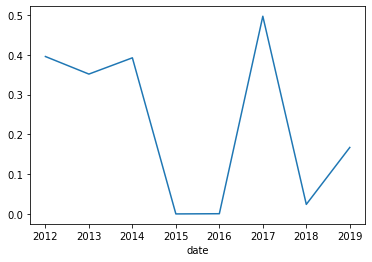

In [1225]:
df_mtd_main.de.plot()

In [1227]:
df_mtd_main.de.mean()

0.22873266193586983

# de: stable and consist
# curr

In [1228]:
df_mtd_main['curr'] = df_mtd.totalCurrentAssets / df_mtd.totalCurrentLiabilities

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


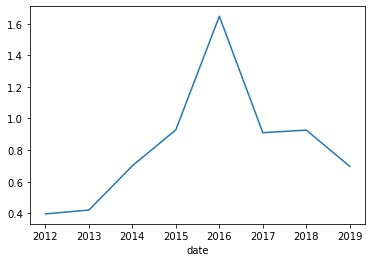

In [1229]:
df_mtd_main.curr.plot()

In [1231]:
df_mtd_main.curr.mean()

0.8280973949813264

In [1232]:
df_mtd['int_cov'] = df_mtd.operatingIncome / df_mtd.interestExpense

In [1234]:
df_mtd.int_cov.mean()

-1.9956707806381333

# curr --> RF 1 
# roe

In [1235]:
df_mtd_main['roe'] = df_mtd_main.netIncome / df_mtd_main.totalStockholdersEquity

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


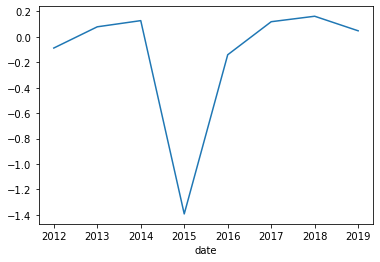

In [1236]:
df_mtd_main.roe.plot()

In [1238]:
df_mtd_main.roe.median()

0.06356594783455333

# roe: pass
# gr

In [1240]:
df_mtd.operatingIncome

date
2012    -33428.0
2013     60445.0
2014    179118.0
2015   -808411.0
2016   -177167.0
2017    160841.0
2018    363271.0
2019    235480.0
Name: operatingIncome, dtype: float64

In [1241]:
#oper income vs interest
annual_growth(df_mtd.operatingIncome.values[-1], -df_mtd.operatingIncome.values[0],7), \
annual_growth(df_mtd.interestExpense.values[-1],df_mtd.interestExpense.values[0],7)

(0.3216623518266475, 0.8484281486638428)

In [1242]:
#tot ass vs liab
annual_growth(df_mtd.totalAssets.values[-1],df_mtd.totalAssets.values[0],7),\
annual_growth(df_mtd.totalLiabilities.values[-1],df_mtd.totalLiabilities.values[0],7)

(0.3048065208373345, 0.3652495585917248)

In [1243]:
df_mtd.shortTermDebt / df_mtd.longTermDebt

date
2012    0.000373
2013    0.000440
2014    0.000303
2015         inf
2016         inf
2017    0.001306
2018    0.025700
2019    0.203247
dtype: float64

In [1249]:
df_mtd.totalStockholdersEquity

date
2012     379104.0
2013     568924.0
2014     866408.0
2015     488003.0
2016     690125.0
2017    1156556.0
2018    1688880.0
2019    1833654.0
Name: totalStockholdersEquity, dtype: float64

In [1248]:
annual_growth(df_mtd.totalStockholdersEquity.values[-1],df_mtd.totalStockholdersEquity.values[0],7),\
annual_growth(df_mtd.eps.values[-1],0.3,7)

(0.2525473319277951, 0.13985228104759662)

# GRS: PASS
# PRIN 3
# BV_GR

In [1252]:
(df_mtd_main.netIncome / df_mtd.totalStockholdersEquity).mean()

-0.1355203097896412

# pass principle 2 and 3a 
# only pb is intrerst but should be covered with operational rev
# princ 3: BV growth 

In [1254]:
df_mtd['bv'] = df_mtd.totalStockholdersEquity / df_mtd.shares

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12bdbd850>,
      dtype=object)

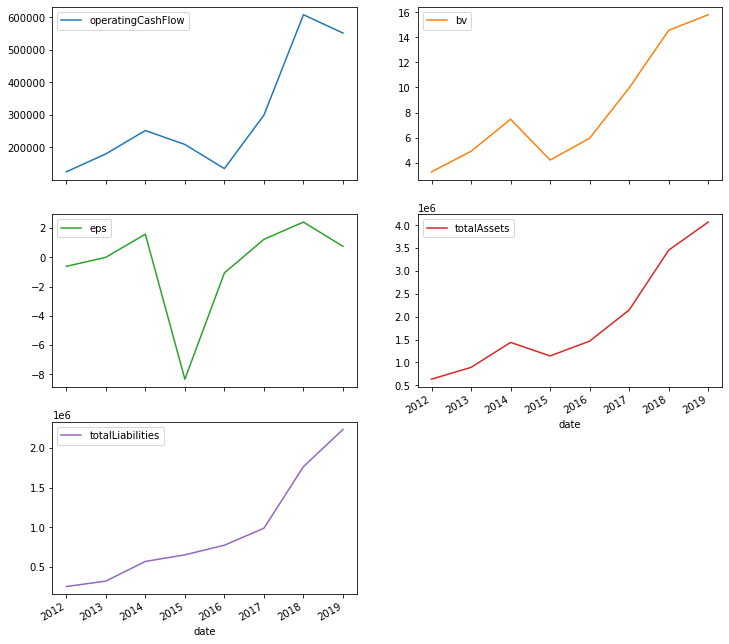

In [1258]:
df_mtd[['operatingCashFlow','bv','eps','totalAssets','totalLiabilities']]\
.plot(subplots = True, layout = (3,-1), figsize = (12,12))

In [1263]:
annual_growth(552042.0,124228.0,7),\
annual_growth(-903976.0,-306916.0,7)


(0.23747401899366527, 0.16686234275178413)

In [1261]:
df_mtd.operatingCashFlow,df_mtd.netCashUsedForInvestingActivites,\
df_mtd.netCashUsedProvidedByFinancingActivities.pct_change().mean()

(date
 2012    124228.0
 2013    179470.0
 2014    251481.0
 2015    208535.0
 2016    134086.0
 2017    299125.0
 2018    608523.0
 2019    552042.0
 Name: operatingCashFlow, dtype: float64,
 date
 2012    -306916.0
 2013    -366939.0
 2014    -570531.0
 2015    -425154.0
 2016    -405640.0
 2017    -824003.0
 2018   -1515253.0
 2019    -903976.0
 Name: netCashUsedForInvestingActivites, dtype: float64,
 0.28234982754155435)

# princip 3 pass
# princ 4
# pe, ps,pb

In [1264]:
df_mtd_main['pe'] = 6.7 / df_mtd.eps
df_mtd_main['ps'] = 6.7 / (df_mtd.revenue / df_mtd.shares)
df_mtd_main['pb'] = 6.7 / df_mtd.bv

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [1268]:
df_mtd_main.pb.mean()

1.073505306176581

# price pass
# valuation

In [1270]:
#cf 
df_mtd.freeCashFlow.median()

-98023.0

In [1275]:
# must use bv instead 
intrinsic_bk(0,10, 0.15,0.2,7)

7.423627299154844

# keep 
# sell half at 8-9 
# KOS 

In [1276]:
dict_kos_cash,errs_kos = url_import(['KOS'], 'cash-flow-statement')
dict_kos_balance,errs_kos = url_import(['KOS'], 'balance-sheet-statement')
dict_kos_income,errs_kos = url_import(['KOS'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/KOS?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/KOS?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/KOS?apikey=cb3b0c371586d9ce915d359479fe1c81


In [1277]:
df_kos_cash = pd.DataFrame(dict_kos_cash)
df_kos_bal = pd.DataFrame(dict_kos_balance)
df_kos_income = pd.DataFrame(dict_kos_income)

In [1278]:
df_kos_bal.date = df_kos_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_kos_cash.date = df_kos_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_kos_income.date = df_kos_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [1279]:
df_kos_bal.set_index(['date'], inplace = True)
df_kos_cash.set_index(['date'], inplace = True)
df_kos_income.set_index(['date'], inplace = True)

In [1280]:
df_kos = pd.concat([df_kos_income,df_kos_bal,df_kos_cash],axis = 1)

In [1281]:
df_kos.drop(['symbol','period'],axis = 1, inplace =True)

In [1282]:
df_kos['shares'] = 583E06

In [1283]:
df_kos = df_kos/1000

In [1284]:
df_kos[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_kos[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [1285]:
df_kos = df_kos.sort_index()

In [1286]:
df_kos_main = df_kos[['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [1287]:
df_kos_main['netIncome'] = df_kos_income['netIncome'] / 1000

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# pric 1
# de

In [1288]:
df_kos_main['de'] = df_kos.totalDebt / df_kos.totalStockholdersEquity

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


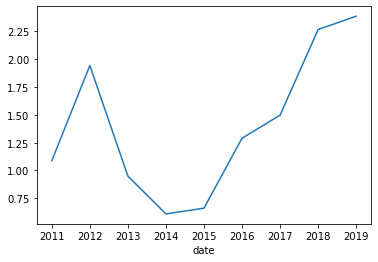

In [1289]:
df_kos_main.de.plot()

In [1291]:
df_kos_main.de.mean()

1.4102898157417922

In [1294]:
annual_growth(2009202.0,1110000.0,8)

0.0769922493430093

In [1292]:
df_kos[['totalStockholdersEquity','totalDebt']]

,totalStockholdersEquity,totalDebt
date,,
2011,1020726.0,1110000.0
2012,1028906.0,2000000.0
2013,992335.0,942000.0
2014,1338959.0,815769.0
2015,1325513.0,876178.0
2016,1081199.0,1394674.0
2017,897112.0,1343097.0
2018,941478.0,2134947.0
2019,841702.0,2009202.0


# de: fail 
# curr

In [1295]:
df_kos['curr'] = df_kos.totalCurrentAssets / df_kos.totalCurrentLiabilities

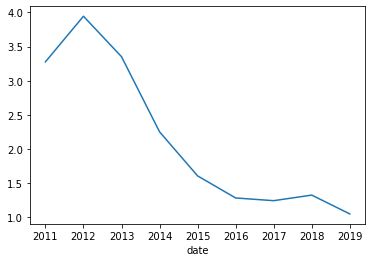

In [1296]:
df_kos.curr.plot()

In [1298]:
df_kos.curr.mean()

2.148288142701416

In [1300]:
df_kos.interestExpense

date
2011    65749.0
2012    52207.0
2013    36811.0
2014        0.0
2015        0.0
2016        0.0
2017        0.0
2018        0.0
2019        0.0
Name: interestExpense, dtype: float64

# curre pass
# roe

In [1301]:
df_kos['roe'] = df_kos_main.netIncome / df_kos.totalStockholdersEquity

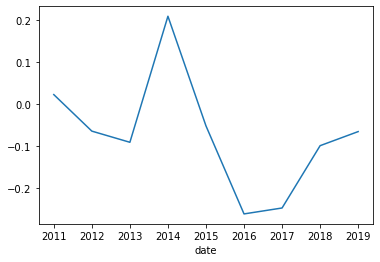

In [1302]:
df_kos.roe.plot()

In [1303]:
df_kos.roe

date
2011    0.021903
2012   -0.065145
2013   -0.091747
2014    0.208647
2015   -0.052686
2016   -0.262468
2017   -0.248344
2018   -0.099833
2019   -0.066267
Name: roe, dtype: float64

In [1304]:
df_kos_main.netIncome / df_kos.totalAssets

date
2011    0.008761
2012   -0.028328
2013   -0.038811
2014    0.093976
2015   -0.021803
2016   -0.084927
2017   -0.069784
2018   -0.022991
2019   -0.012920
dtype: float64

# roe: fail, rf! 
# bv

In [1305]:
df_kos['bv']=df_kos.totalStockholdersEquity/df_kos.shares

In [1306]:
df_kos.dividendsPaid

date
2011        0.0
2012        0.0
2013        0.0
2014        0.0
2015        0.0
2016        0.0
2017        0.0
2018        0.0
2019   -72599.0
Name: dividendsPaid, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12eaa6750>,
      dtype=object)

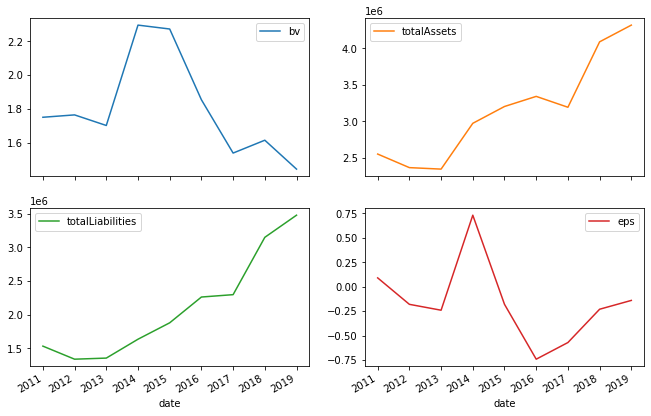

In [1308]:
df_kos[['bv','totalAssets','totalLiabilities','eps']].plot(subplots = True,layout = (3,-1),
                                                          figsize = (11,11))

In [1312]:
annual_growth(187414.0,364909.0,8)

-0.07991662839784208

In [1313]:
df_kos.freeCashFlow.mean()

230699.33333333334

In [1318]:
cf_est = [230699]
gr = [0.05]
dr = [0.2,0.25]

In [1319]:
intrinsic_cash(cf_est,gr,dr,lgr,df_kos.shares.values[0],8)

defaultdict(list, {'230.699,5.0%': [2.5390226026033043, 1.9482708021614985]})

In [1320]:
df_kos.bv

date
2011    1.750816
2012    1.764847
2013    1.702118
2014    2.296671
2015    2.273607
2016    1.854544
2017    1.538786
2018    1.614885
2019    1.443743
Name: bv, dtype: float64

In [1322]:
intrinsic_bk(0,1.44,0.03,0.15,8)

0.5963175167916467

# sell at 2 
# icd 

In [1323]:
dict_icd_cash,errs_icd = url_import(['ICD'], 'cash-flow-statement')
dict_icd_balance,errs_icd = url_import(['ICD'], 'balance-sheet-statement')
dict_icd_income,errs_icd = url_import(['ICD'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/ICD?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/ICD?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/ICD?apikey=cb3b0c371586d9ce915d359479fe1c81


In [1324]:
df_icd_cash = pd.DataFrame(dict_icd_cash)
df_icd_bal = pd.DataFrame(dict_icd_balance)
df_icd_income = pd.DataFrame(dict_icd_income)

In [1325]:
df_icd_bal.date = df_icd_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_icd_cash.date = df_icd_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_icd_income.date = df_icd_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [1326]:
df_icd_bal.set_index(['date'], inplace = True)
df_icd_cash.set_index(['date'], inplace = True)
df_icd_income.set_index(['date'], inplace = True)

In [1327]:
df_icd = pd.concat([df_icd_income,df_icd_bal,df_icd_cash],axis = 1)

In [1328]:
df_icd.drop(['symbol','period'],axis = 1, inplace =True)

In [1330]:
df_icd['shares'] = 3.81E06

In [1331]:
df_icd = df_icd/1000

In [1332]:
df_icd[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_icd[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [1333]:
df_icd = df_icd.sort_index()

In [1334]:
df_icd_main = df_icd[['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [1335]:
df_icd_main['netIncome'] = df_icd_income['netIncome'] / 1000

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# prin 1
# de 

In [1336]:
df_icd_main['de'] = df_icd.totalDebt / df_icd.totalStockholdersEquity

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


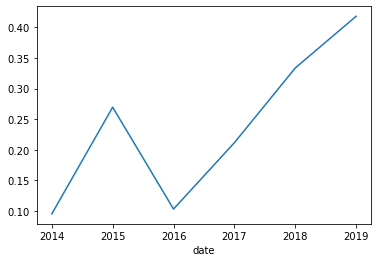

In [1337]:
df_icd_main.de.plot()

In [1339]:
df_icd_main.de.mean()

0.238464758658419

# de pass
# curr

In [1340]:
df_icd['curr'] = df_icd.totalCurrentAssets / df_icd.totalCurrentLiabilities

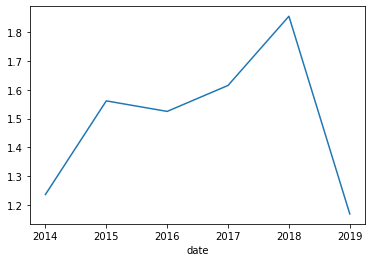

In [1343]:
df_icd.curr.plot()

# curr pass 
# roe

In [1345]:
df_icd['roe'] = df_icd_main.netIncome/df_icd.totalStockholdersEquity

In [1346]:
df_icd.roe

date
2014   -0.118985
2015   -0.033858
2016   -0.086211
2017   -0.103184
2018   -0.051063
2019   -0.183319
Name: roe, dtype: float64

In [1351]:
df_icd.operatingIncome

date
2014   -33067.0
2015    -4951.0
2016   -18931.0
2017   -21028.0
2018   -12340.0
2019   -46495.0
Name: operatingIncome, dtype: float64

In [1352]:
df_icd_main.netIncome / df_icd.totalStockholdersEquity

date
2014   -0.118985
2015   -0.033858
2016   -0.086211
2017   -0.103184
2018   -0.051063
2019   -0.183319
dtype: float64

In [1353]:
df_icd['bv'] = df_icd.totalStockholdersEquity /df_icd.shares

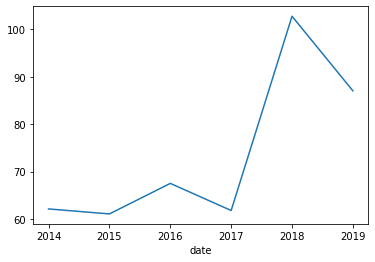

In [1354]:
df_icd.bv.plot()

In [1356]:
df_icd.netCashUsedProvidedByFinancingActivities

date
2014    116904.0
2015     39427.0
2016      4812.0
2017     20623.0
2018     18826.0
2019     -6593.0
Name: netCashUsedProvidedByFinancingActivities, dtype: float64

In [1360]:
df_icd.bv.mean()

73.72423447069116

In [1359]:
annual_growth(87.033071,62.135433,5)

0.06971724162366888

In [1363]:
intrinsic_bk(0,73,0.07,0.25,5)

33.54993503145166